# CSCA-5522: Data Mining Project #
#### A Data Mining Exploration with NFL Big Data Bowl Datasets. ####
    
* Author: Alexander Meau  
* Email: alme9155@colorado.edu  
* GitHub: [https://github.com/alme9155/csca-5522/tree/main](https://github.com/alme9155/csca-5522/tree/main)  

In [1]:
import numpy as np
import pandas as pd
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the data directory in Google Drive
data_dir = '/content/drive/MyDrive/nfl-big-data'

# List all files in the data directory to verify
print("Files in data directory:")
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Mounted at /content/drive
Files in data directory:
/content/drive/MyDrive/nfl-big-data/games.csv
/content/drive/MyDrive/nfl-big-data/player_play.csv
/content/drive/MyDrive/nfl-big-data/players.csv
/content/drive/MyDrive/nfl-big-data/plays.csv
/content/drive/MyDrive/nfl-big-data/tracking_week_1.csv
/content/drive/MyDrive/nfl-big-data/tracking_week_2.csv
/content/drive/MyDrive/nfl-big-data/tracking_week_3.csv
/content/drive/MyDrive/nfl-big-data/tracking_week_4.csv
/content/drive/MyDrive/nfl-big-data/tracking_week_5.csv
/content/drive/MyDrive/nfl-big-data/tracking_week_6.csv
/content/drive/MyDrive/nfl-big-data/tracking_week_7.csv
/content/drive/MyDrive/nfl-big-data/tracking_week_8.csv
/content/drive/MyDrive/nfl-big-data/tracking_week_9.csv


## I. Brief description of the problem and data ##

This data mining project aims to predict post-snap play outcomes (e.g., pass completion, yards gained, or tackle success) in NFL pre-season games using Graph Neural network. My project focus is to analyze pre-snap positioning and dynamic attributes of both offensive and defensive players (e.g., quarterback, wide receivers, running backs) to predict post-snap play success.

This work will leverage the NFL Big Data Bowl 2025 dataset, which includes pre-snap statistics of player position, acceleration of every game play, and their corresponding post-snap outcome.

### Dataset: ####
* Dataset include 4 categories of data:
  * **players.csv**: Contains player metadata, including IDs, names, positions, and player physical attributes.
  * **plays.csv**: Describes play-level information, such as game context, play  type, and outcomes.
  * **player_play.csv**: Links players to specific plays, detailing their involvement and roles in each play.
  * **tracking_week_x.csv**: Provides frame-by-frame player tracking data, capturing positions, speeds, and orientations for each week.
  
### Data Size and Dimension ####
* **players.csv**: ~2,000 player records
* **plays.csv**: ~10,000-20,000 play records and outcomes.
* **player_play.csv**: ~100,000 records linking players to specific plays.
* **tracking_week_x.csv**: ~10-100 million rows across weeks 1-9, capturing player coordinates, speed, and orientation at 10 Hz.


## II. Exploratory Data Analysis (EDA) ##
- Examine video quality:
  - Dimension (width x height)
  - Frame Count and Frame per secound
  - Total count of video clips
  - Total count of video category

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, glob, math
from scipy.spatial import distance_matrix

In [3]:
# file path
# data_dir = "/kaggle/input/nfl-big-data-bowl-2025-archived-data/"
players_file = f"{data_dir}/players.csv"
plays_file = f"{data_dir}/plays.csv"
player_play_file = f"{data_dir}/player_play.csv"
games_file = f"{data_dir}/games.csv"
tracking_files = [f"{data_dir}/tracking_week_{i}.csv" for i in range(1, 10)]

# df
players_df = pd.read_csv(players_file)
plays_df = pd.read_csv(plays_file)
player_play_df = pd.read_csv(player_play_file)
games_df  = pd.read_csv(games_file)

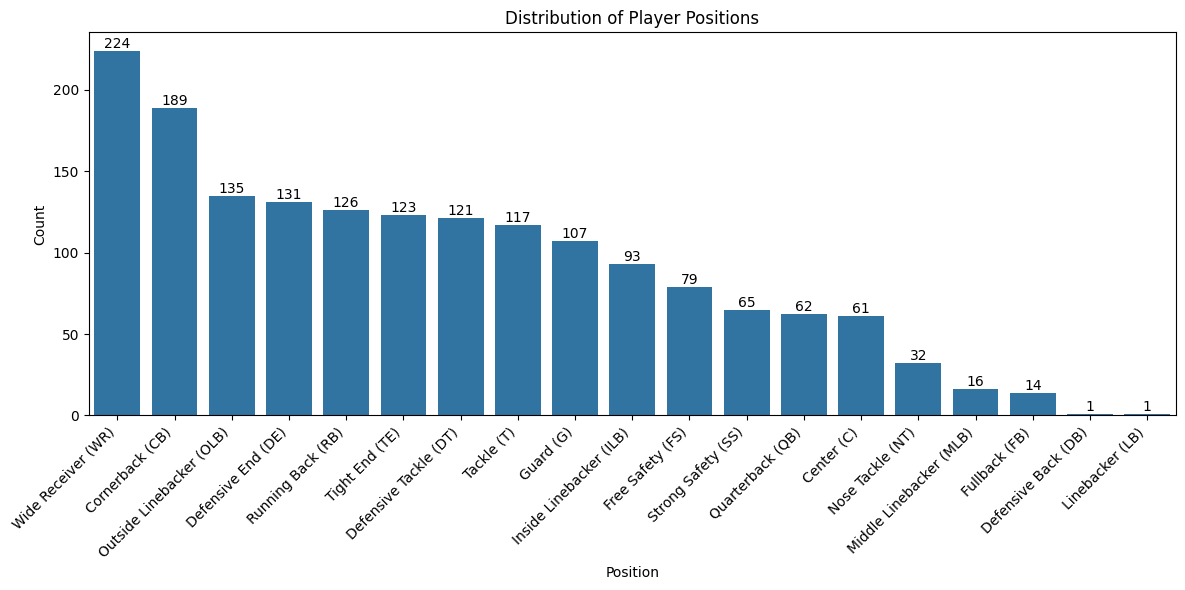

In [4]:
position_translation = {
    'WR': 'Wide Receiver (WR)', 'CB': 'Cornerback (CB)', 'OLB': 'Outside Linebacker (OLB)',
    'DE': 'Defensive End (DE)', 'RB': 'Running Back (RB)', 'TE': 'Tight End (TE)',
    'DT': 'Defensive Tackle (DT)', 'T': 'Tackle (T)', 'G': 'Guard (G)',
    'ILB': 'Inside Linebacker (ILB)', 'FS': 'Free Safety (FS)', 'SS': 'Strong Safety (SS)',
    'QB': 'Quarterback (QB)', 'C': 'Center (C)', 'NT': 'Nose Tackle (NT)',
    'MLB': 'Middle Linebacker (MLB)', 'FB': 'Fullback (FB)', 'DB': 'Defensive Back (DB)',
    'LB': 'Linebacker (LB)', 'K': 'Kicker (K)', 'P': 'Punter (P)', 'LS': 'Long Snapper (LS)',
}


position_counts = players_df['position'].value_counts()
position_counts_df = position_counts.reset_index()
position_counts_df.columns = ['Position', 'Count']
position_counts_df['Position_Full'] = position_counts_df['Position'].map(position_translation)

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=position_counts_df, x='Position_Full', y='Count')
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=10)
plt.title("Distribution of Player Positions")
plt.xlabel("Position")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
# Label prep
plays_df = plays_df.copy()
plays_df["passResultNorm"] = plays_df["passResult"].astype("string").str.strip().str.upper()

is_pass        = plays_df["passResultNorm"].isin(["C","I","S","IN"])
is_completed   = plays_df["passResultNorm"].eq("C")
yg             = plays_df["yardsGained"].fillna(0)

plays_df["isPassPlay"]            = is_pass
plays_df["isCompleted"]           = is_completed
plays_df["isWinningPass"]         = is_completed & (yg > 0)      # completed + positive yards
plays_df["isCompletedZeroGain"]   = is_completed & (yg == 0)     # completed + exactly 0 yards
plays_df["isCompletedNoGain"]     = is_completed & (yg <= 0)     # completed + zero OR negative
plays_df["isCompletedNegGain"]    = is_completed & (yg < 0)      # completed + negative yards

print("Winning passes:", int(plays_df["isWinningPass"].sum()))
print("Completed zero-gain:", int(plays_df["isCompletedZeroGain"].sum()))


Winning passes: 5347
Completed zero-gain: 94



Loading plays.csv...
Plays Data Row Count: 16124

Pass Result Distribution:
  Pass_Result  Count           Pass_Result_Full
0         NaN   6388     Non-Pass/Unknown (NaN)
1           C   5624         Completed Pass (C)
2           I   2911        Incomplete Pass (I)
3           S    608                 Sacked (S)
4           R    400  Interception Returned (R)
5          IN    193          Interception (IN)


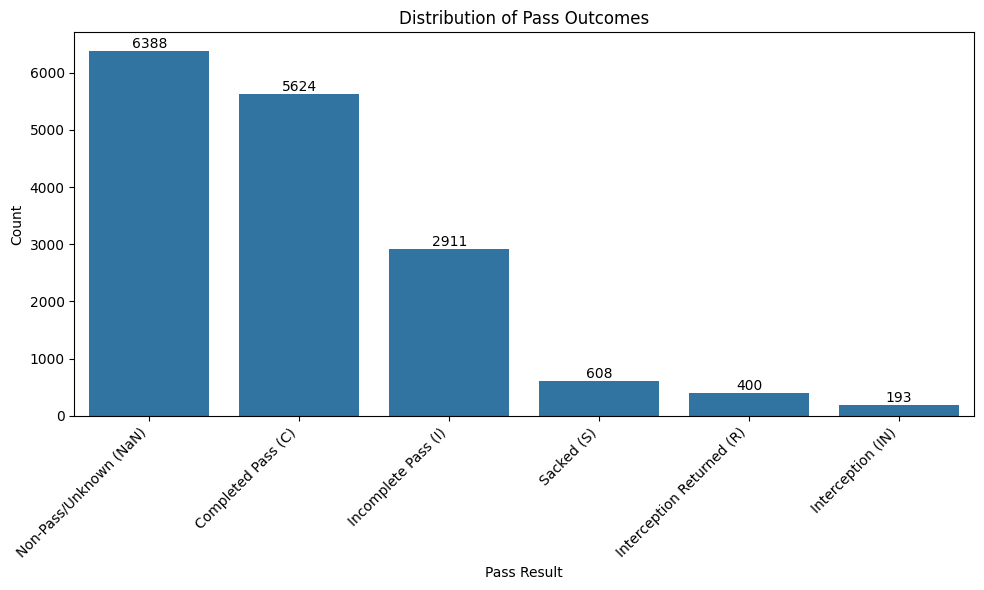

In [6]:
print("\nLoading plays.csv...")
pass_result_translation = {
    'NaN': 'Non-Pass/Unknown (NaN)',
    'C': 'Completed Pass (C)',
    'I': 'Incomplete Pass (I)',
    'S': 'Sacked (S)',
    'R': 'Interception Returned (R)',
    'IN': 'Interception (IN)'
}
plays_row_count = len(plays_df)
print(f"Plays Data Row Count: {plays_row_count}")

# Compute pass result distribution dynamically
pass_result_counts = plays_df['passResult'].value_counts(dropna=False).reset_index()
pass_result_counts.columns = ['Pass_Result', 'Count']
pass_result_counts['Pass_Result'] = pass_result_counts['Pass_Result'].fillna('NaN').astype(str)
pass_result_counts['Pass_Result_Full'] = pass_result_counts['Pass_Result'].map(pass_result_translation)
print("\nPass Result Distribution:")
print(pass_result_counts[['Pass_Result', 'Count', 'Pass_Result_Full']])

# Visualize pass result distribution with counts
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=pass_result_counts, x='Pass_Result_Full', y='Count')
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=10)
plt.title("Distribution of Pass Outcomes")
plt.xlabel("Pass Result")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Player-Play Data Row Count: 354727

Offensive vs Defensive Players:
is_offensive
Defense    298932
Offense     55795
Name: count, dtype: int64


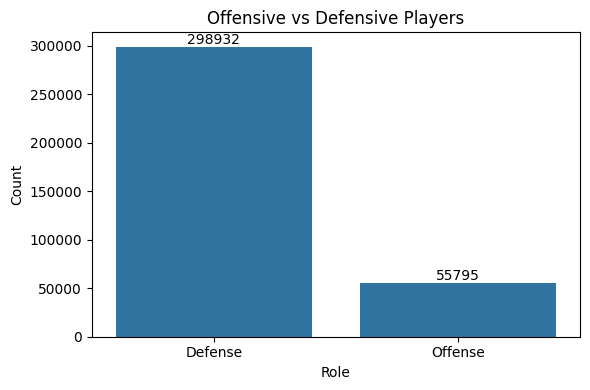

In [7]:
player_play_row_count = len(player_play_df)
print(f"Player-Play Data Row Count: {player_play_row_count}")
# print("Player-Play Data Info:")
#print(player_play_df.info())

# Infer offensive players using relevant columns
offensive_cols = ['hadRushAttempt', 'hadDropback', 'hadPassReception', 'wasTargettedReceiver', 'wasRunningRoute']
player_play_df['is_offensive'] = player_play_df[offensive_cols].any(axis=1).astype(int)
offense_defense_counts = player_play_df['is_offensive'].value_counts().rename({1: 'Offense', 0: 'Defense'})
print("\nOffensive vs Defensive Players:")
print(offense_defense_counts)

# Visualize offense vs defense distribution with counts
plt.figure(figsize=(6, 4))
bar_plot = sns.barplot(x=offense_defense_counts.index, y=offense_defense_counts.values)
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=10)
plt.title("Offensive vs Defensive Players")
plt.xlabel("Role")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Processing /content/drive/MyDrive/nfl-big-data/tracking_week_1.csv...
Tracking Data Row Count (Week 1): 7104700


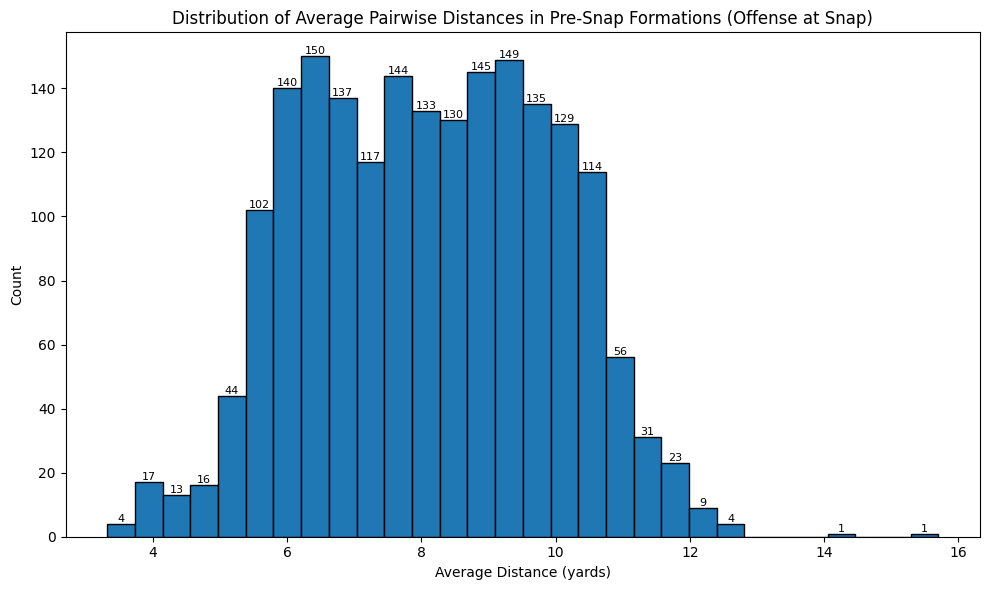


Summary of Formation Statistics:
Average Pairwise Distance: 8.13 yards
Average Formation Spread:  8.03 yards


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def pairwise_avg_distance(coords: np.ndarray) -> float:
    """Average pairwise Euclidean distance for coords shaped (N,2)."""
    if coords.shape[0] < 2:
        return 0.0
    diffs = coords[:, None, :] - coords[None, :, :]
    d = np.sqrt((diffs ** 2).sum(axis=-1))
    n = coords.shape[0]
    triu = d[np.triu_indices(n, k=1)]
    return float(triu.mean()) if triu.size else 0.0

def process_tracking_data(tracking_file, plays_df, player_play_df, chunk_size=100000):
    """
    Process tracking data in chunks to extract SNAP-frame offensive player data
    and compute formation statistics.

    Key fixes:
    - tracking has no 'position' → merge positions from player_play/players
    - side column is 'club' with team abbreviations → drop only 'football'
    - infer offense from QB's club at snap
    """
    print(f"\nProcessing {tracking_file}...")
    tracking_chunks = pd.read_csv(tracking_file, chunksize=chunk_size)

    # Build fallback position lookup from player_play_df (or players_df by nflId)
    pos_col = next((c for c in ["position", "officialPosition", "pff_positionLinedUp"]
                    if c in player_play_df.columns), None)
    if pos_col:
        pp_pos = (player_play_df[["gameId","playId","nflId",pos_col]]
                  .rename(columns={pos_col: "pp_position"}))
    else:
        pp_pos = player_play_df[["gameId","playId","nflId"]].copy()
        if "position" in players_df.columns:
            pp_pos = pp_pos.merge(
                players_df[["nflId","position"]].rename(columns={"position":"pp_position"}),
                on="nflId", how="left"
            )
        else:
            pp_pos["pp_position"] = pd.NA
    pp_pos["pp_position"] = pp_pos["pp_position"].astype("string").str.strip().str.upper()

    pre_snap_frames = []
    formation_stats = {'avg_player_distance': [], 'formation_spread': []}
    row_count = 0

    for chunk in tracking_chunks:
        row_count += len(chunk)

        # Required columns
        needed = {"gameId","playId","nflId","x","y","event"}
        missing = needed - set(chunk.columns)
        if missing:
            raise KeyError(f"tracking chunk missing columns: {missing}")

        # team/side column is 'team' or 'club' (your file uses 'club')
        team_col = "team" if "team" in chunk.columns else ("club" if "club" in chunk.columns else None)
        if team_col is None:
            raise KeyError("tracking chunk missing 'team'/'club' column (team abbrev or 'football')")

        # 1) Snap-frame rows
        pre_snap_chunk = chunk[chunk['event'].astype('string').str.strip().eq('ball_snap')]
        if pre_snap_chunk.empty:
            continue

        # 2) Keep players only: **drop ONLY 'football'**, since values are team abbreviations (IND/HOU/…)
        pre_snap_chunk = pre_snap_chunk[pre_snap_chunk[team_col].astype('string').str.lower() != 'football']
        if pre_snap_chunk.empty:
            continue

        # 3) Merge positions (tracking has no 'position' in your file)
        pre_snap_chunk = pre_snap_chunk.merge(
            pp_pos, on=["gameId","playId","nflId"], how="left"
        )
        pre_snap_chunk["position_final"] = pre_snap_chunk["pp_position"].astype("string").str.strip().str.upper()

        # 4) Per play: find QB row to infer offense side (QB's club), keep only that side
        kept_rows = []
        for (game_id, play_id), group in pre_snap_chunk.groupby(['gameId', 'playId']):
            qb_rows = group[group["position_final"] == "QB"]
            if qb_rows.empty:
                continue  # cannot infer offense side; skip
            offense_side = str(qb_rows.iloc[0][team_col])  # e.g., 'IND', 'HOU', ...
            group_off = group[group[team_col] == offense_side]
            if group_off.empty:
                continue
            kept_rows.append(group_off)

            # 5) Formation stats on the offense at snap
            coords = group_off[['x', 'y']].to_numpy(dtype=np.float32, copy=False)
            if coords.shape[0] > 1:
                avg_dist = pairwise_avg_distance(coords)
                spread   = float(np.std(coords, axis=0).sum())  # std_x + std_y
                formation_stats['avg_player_distance'].append(avg_dist)
                formation_stats['formation_spread'].append(spread)

        if kept_rows:
            pre_snap_frames.append(pd.concat(kept_rows, ignore_index=True))

    return (pd.concat(pre_snap_frames, ignore_index=True) if pre_snap_frames else pd.DataFrame(),
            formation_stats, row_count)

# --- Run (Week 1 example) with your same calls
tracking_df, formation_stats, tracking_row_count = process_tracking_data(
    tracking_files[0], plays_df, player_play_df
)
print(f"Tracking Data Row Count (Week 1): {tracking_row_count}")

if not tracking_df.empty and formation_stats['avg_player_distance']:
    plt.figure(figsize=(10, 6))
    counts, bins, _ = plt.hist(formation_stats['avg_player_distance'], bins=30, edgecolor='black')
    for count, binl, binr in zip(counts.astype(int), bins[:-1], bins[1:]):
        if count > 0:
            plt.text((binl + binr) / 2, count, f'{count}', ha='center', va='bottom', fontsize=8)
    plt.title("Distribution of Average Pairwise Distances in Pre-Snap Formations (Offense at Snap)")
    plt.xlabel("Average Distance (yards)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

print("\nSummary of Formation Statistics:")
if formation_stats['avg_player_distance']:
    print(f"Average Pairwise Distance: {np.mean(formation_stats['avg_player_distance']):.2f} yards")
    print(f"Average Formation Spread:  {np.mean(formation_stats['formation_spread']):.2f} yards")
else:
    print("No formation stats collected (no snap frames or no offense rows).")


## Data Preparation / Normalization ##

* Enforce consistent key dtypes to avoid downstream join issues.
* Load tracking files with essential columns (IDs + movement features).
* Merge player info: add *position*, *offenseDefense*, *playerPlayRole*.
* Attach play labels: *yardsGained*, *passResult*, *playResult*, *playDirection*.
* Standardize field so offense always moves left -> right.
* Select one reference frame per play (ball snap or first frame).
* Transform features: convert angles to sin/cos, scale numeric values.
* Encode categorical columns into integer indices.
* Build feature table & index map for graph construction.

In [9]:
import os, glob
import pandas as pd
import numpy as np

# 1. Normalize base dataframes
for df in [plays_df, player_play_df, games_df, players_df]:
    for col in ["gameId", "playId", "nflId", "frameId"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

if "gameDate" in games_df.columns and not pd.api.types.is_datetime64_any_dtype(games_df["gameDate"]):
    games_df["gameDate"] = pd.to_datetime(games_df["gameDate"], errors="coerce")

# 2. Load tracking files
# Use explicit week list if all 1–9 files exist; otherwise use glob
explicit = [os.path.join(data_dir, f"tracking_week_{i}.csv") for i in range(1, 10)]
globbed  = sorted(glob.glob(os.path.join(data_dir, "tracking_week_*.csv")))
files = explicit if all(os.path.exists(f) for f in explicit) else globbed
if not files:
    raise FileNotFoundError("No tracking_week_*.csv files found.")

# Define required columns and dtypes
desired = ["gameId", "playId", "nflId", "frameId", "event", "team", "club",
           "x", "y", "s", "a", "dis", "o", "dir", "playDirection"]

read_dtypes = {
    "gameId": "Int64", "playId": "Int64", "frameId": "Int64", "nflId": "Int64",
    "x": "float32", "y": "float32", "s": "float32", "a": "float32",
    "dis": "float32", "o": "float32", "dir": "float32"
}

# 3. Parse & normalize tracking data
tracking_list = []
for f in files:
    df = pd.read_csv(f, usecols=lambda c: c in desired, dtype=read_dtypes, low_memory=False)

    # Fill missing columns
    for c in desired:
        if c not in df.columns:
            df[c] = (np.nan if c in ["x","y","s","a","dis","o","dir"] else pd.NA)

    # Normalize team/club to side
    side = df["team"].astype("string") if "team" in df.columns else pd.Series(pd.NA, index=df.index, dtype="string")
    club = df["club"].astype("string") if "club" in df.columns else pd.Series(pd.NA, index=df.index, dtype="string")
    df["side"] = side.fillna(club).str.strip()

    # Drop 'football' rows
    df = df[df["side"].str.lower() != "football"].copy()

    # Reorder + assign normalized side
    df = df[desired].assign(side=df["side"])

    tracking_list.append(df)

# Concatenate all weeks
tracking_df = pd.concat(tracking_list, ignore_index=True)

# 4. Normalize strings + re-align types
# Strip strings in categorical columns
for c in ["event", "playDirection", "side", "team", "club"]:
    if c in tracking_df.columns:
        tracking_df[c] = tracking_df[c].str.strip()

# 5. Merge game metadata
if "games_df" in globals() and "gameId" in games_df.columns:
    meta_cols = [c for c in ["gameId", "season", "week", "homeTeamAbbr", "visitorTeamAbbr", "gameDate"] if c in games_df.columns]
    if meta_cols:
        tracking_df = tracking_df.merge(games_df[meta_cols].drop_duplicates(), on="gameId", how="left")

# 6. Sort tracking_df for frame order
sort_cols = [c for c in ["season", "week", "gameId", "playId", "frameId", "nflId"] if c in tracking_df.columns]
if sort_cols:
    tracking_df.sort_values(sort_cols, inplace=True, kind="mergesort", ignore_index=True)

# 7. Prepare player position mapping (for feature engineering)
pos_col = next((c for c in ["position", "officialPosition", "pff_positionLinedUp"]
                if c in player_play_df.columns), None)

if pos_col:
    pp_pos = player_play_df[["gameId", "playId", "nflId", pos_col]].rename(columns={pos_col: "pp_position"})
else:
    pp_pos = player_play_df[["gameId", "playId", "nflId"]].copy()
    if "position" in players_df.columns:
        pp_pos = pp_pos.merge(
            players_df[["nflId", "position"]].rename(columns={"position": "pp_position"}),
            on="nflId", how="left"
        )
    else:
        pp_pos["pp_position"] = pd.NA

pp_pos["pp_position"] = pp_pos["pp_position"].astype("string").str.strip().str.upper()

# ===============================
# Summary
# ===============================
print('✅ Data normalization complete.')
print(f"  players_df:     {players_df.shape}")
print(f"  plays_df:       {plays_df.shape}")
print(f"  player_play_df: {player_play_df.shape}")
print(f"  games_df:       {games_df.shape}")
print(f"  tracking_df:    {tracking_df.shape} from {len(files)} tracking files")


# (Optional quick sanity prints)
# print("event sample:", tracking_df["event"].dropna().unique()[:10])
# print("side sample:", tracking_df["side"].dropna().unique()[:10])


✅ Data normalization complete.
  players_df:     (1697, 7)
  plays_df:       (16124, 57)
  player_play_df: (354727, 51)
  games_df:       (136, 9)
  tracking_df:    (56747922, 21) from 9 tracking files


In [10]:
# sanity test
# 1. Look for snap rows in tracking
snap_rows = tracking_df[tracking_df["event"].str.strip().eq("ball_snap")]
print("snap rows:", len(snap_rows))
print("unique plays with snap:", snap_rows[["gameId", "playId"]].drop_duplicates().shape[0])

# 2. Build pp_position mapping (from player_play_df or fallback to players_df)
pos_col = next((c for c in ["position", "officialPosition", "pff_positionLinedUp"] if c in player_play_df.columns), None)

if pos_col:
    pp_pos = player_play_df[["gameId", "playId", "nflId", pos_col]].rename(columns={pos_col: "pp_position"})
else:
    pp_pos = player_play_df[["gameId", "playId", "nflId"]].merge(
        players_df[["nflId", "position"]].rename(columns={"position": "pp_position"}),
        on="nflId", how="left"
    )

pp_pos["pp_position"] = pp_pos["pp_position"].astype("string").str.strip().str.upper()

# 3. Merge positions with snap frames and look for QBs
snap_m = snap_rows.merge(pp_pos, on=["gameId", "playId", "nflId"], how="left")
qb_plays = snap_m[snap_m["pp_position"] == "QB"][["gameId", "playId"]].drop_duplicates()
print("plays with QB @ snap:", qb_plays.shape[0])

# 4. Optional peeks
print("pp_position sample:", snap_m["pp_position"].dropna().unique()[:10])
print("side sample at snap:", snap_m["side"].dropna().unique()[:10] if "side" in snap_m else "(no side column in this DF)")


snap rows: 353364
unique plays with snap: 16062
plays with QB @ snap: 16062
pp_position sample: <StringArray>
['G', 'ILB', 'DT', 'C', 'WR', 'CB', 'DE', 'T', 'QB', 'SS']
Length: 10, dtype: string
side sample at snap: <StringArray>
['BUF', 'LA', 'NO', 'ATL', 'CLE', 'CAR', 'SF', 'CHI', 'CIN', 'PIT']
Length: 10, dtype: string


# Preprocessing and Feature Engineering

* Pick the reference frame for each play (prefer ball snap, fallback to earliest frame).
* Keep only player rows (filter out non-player rows, e.g., football).
* Merge in position information from player_play_df or fallback to players_df.
* Create a unified position column (position_final) for downstream role-based logic.
* Normalize team side labels (e.g., offense vs defense) using team or club.
* Convert orientation (o) and direction (dir) angles into cosine/sine vectors.
* Scale numeric features (like x, y, s, a, etc.) using StandardScaler to standardized float32.
* Map categorical features (like position, side, offenseDefense) into integer indices.
* Build a clean feature matrix with IDs, scaled features, categorical indices, and row mappings for each (gameId, playId, nflId).


In [11]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Pick reference frame (ball_snap or fallback)
snap = (
    tracking_df.loc[tracking_df["event"].str.lower().eq("ball_snap"), ["gameId", "playId", "frameId"]]
    .groupby(["gameId", "playId"], sort=False, as_index=False)["frameId"].min()
    .rename(columns={"frameId": "snapFrame"})
)

ref = tracking_df.merge(snap, on=["gameId", "playId"], how="left")
ref["useFrame"] = np.where(
    ref["snapFrame"].notna(),
    ref["snapFrame"],
    ref.groupby(["gameId", "playId"])["frameId"].transform("min")
)
ref = ref[ref["frameId"] == ref["useFrame"]]

# Keep player rows only (football removed earlier)
players_frame = ref[ref["nflId"].notna()].copy()

# 2. Merge positions & unify into 'position_final'
players_frame = players_frame.merge(pp_pos, on=["gameId", "playId", "nflId"], how="left")
if "position" in players_frame.columns:
    players_frame["position"] = players_frame["position"].astype("string").str.strip().str.upper()
else:
    players_frame["position"] = pd.Series(pd.NA, index=players_frame.index, dtype="string")

players_frame["position_final"] = (
    players_frame["position"].fillna(players_frame["pp_position"])
).astype("string").str.strip().str.upper()

# Normalize side if present
if "side" in players_frame.columns:
    players_frame["side"] = players_frame["side"].astype("string").str.strip().str.upper()

# 3. Convert angles to sin/cos vectors
def ang2vec(deg_series: pd.Series):
    rad = np.deg2rad(deg_series.astype(np.float32).to_numpy())
    return np.cos(rad), np.sin(rad)

if "o" in players_frame.columns:
    players_frame["o_cos"], players_frame["o_sin"] = ang2vec(players_frame["o"])
if "dir" in players_frame.columns:
    players_frame["dir_cos"], players_frame["dir_sin"] = ang2vec(players_frame["dir"])

# Final numeric columns
num_cols = [c for c in ["x", "y", "s", "a", "dis", "o_cos", "o_sin", "dir_cos", "dir_sin"] if c in players_frame.columns]

# 4. Standardize numeric features
if num_cols:
    scaler = StandardScaler()
    scaled = scaler.fit_transform(players_frame[num_cols].fillna(0.0).to_numpy(np.float32))
    scaled = np.nan_to_num(scaled, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    players_frame[num_cols] = scaled

# 5. Encode categorical columns into indices
def build_vocab(series: pd.Series):
    vals = [v for v in series.dropna().astype(str).unique()]
    return {v: i + 1 for i, v in enumerate(sorted(vals))}  # reserve 0 for unknown

cat_candidates = ["position_final", "pp_position", "position", "playerPlayRole", "offenseDefense", "side"]
cat_cols = [c for c in cat_candidates if c in players_frame.columns]

vocabs = {c: build_vocab(players_frame[c]) for c in cat_cols}
for c in cat_cols:
    players_frame[f"{c}_idx"] = players_frame[c].map(vocabs[c]).fillna(0).astype(np.int32)

# 6. Build final feature matrix and index map
feat_cols = ["gameId", "playId", "nflId"] + num_cols + [f"{c}_idx" for c in cat_cols]
feat_df = players_frame[feat_cols].reset_index(drop=True)
feat_df["__row_ix__"] = np.arange(len(feat_df), dtype=np.int64)
# (gameId, playId, nflId) → feature matrix row index
key_to_ix = dict(zip(zip(feat_df["gameId"], feat_df["playId"], feat_df["nflId"]), feat_df["__row_ix__"]))
# Dense numeric matrix (float32, CUDA safe)
num_mat = (
    feat_df[num_cols].to_numpy(dtype=np.float32)
    if num_cols else np.zeros((len(feat_df), 0), dtype=np.float32)
)

print("Feature engineering complete.")
print(f"  Numeric features:      {num_cols}")
print(f"  Categorical features:  {cat_cols}")
print(f"  Feature matrix shape:  {num_mat.shape}")


Feature engineering complete.
  Numeric features:      ['x', 'y', 's', 'a', 'dis', 'o_cos', 'o_sin', 'dir_cos', 'dir_sin']
  Categorical features:  ['position_final', 'pp_position', 'position', 'side']
  Feature matrix shape:  (354728, 9)


In [12]:
# ----------------------------
# SANITY CHECK BLOCK
# ----------------------------

# ===== SANITY CHECKS =====
print("\n=== Basic shapes ===")
print("feat_df shape:", feat_df.shape)
print("num_mat shape:", num_mat.shape)
print("num_cols:", num_cols)
print("cat_cols:", cat_cols)


# 1. Uniqueness & ID check
print("\n=== Key uniqueness ===")
n_keys = feat_df[["gameId", "playId", "nflId"]].shape[0]
n_unique = feat_df[["gameId", "playId", "nflId"]].drop_duplicates().shape[0]
print("rows:", n_keys, "| unique keys:", n_unique)
assert n_keys == n_unique, "Duplicate (gameId, playId, nflId) rows found in feat_df"

# 2. Reference frame check
print("\n=== Reference frame check ===")
counts_per_entity = players_frame.groupby(["gameId", "playId", "nflId"]).size()
multi_refs = (counts_per_entity > 1).sum()
print("entities with >1 row at ref frame:", int(multi_refs))
assert multi_refs == 0, "Multiple rows found at ref frame per player"

# 3. Side value check
if "side" in players_frame.columns:
    sides = players_frame["side"].dropna().unique()
    print("\n=== Side values ===")
    print(sides[:12])
    assert not any(str(s).lower() == "football" for s in sides), "'football' leaked into side column"

# 4. Position availability
print("\n=== Position label check ===")
pos_col_used = "position_final" if "position_final" in players_frame.columns else (
    "pp_position" if "pp_position" in players_frame.columns else (
        "position" if "position" in players_frame.columns else None
    )
)
print("Position column used:", pos_col_used)
assert pos_col_used is not None, "No usable position column available"
print("Top positions:\n", players_frame[pos_col_used].value_counts().head(10))

# 5. QB / WR counts
qb_per_play = players_frame[players_frame[pos_col_used] == "QB"].groupby(["gameId", "playId"]).size()
wr_per_play = players_frame[players_frame[pos_col_used] == "WR"].groupby(["gameId", "playId"]).size()
print("\nPlays with QB at ref frame:", qb_per_play.shape[0])
print("Plays with WR at ref frame:", wr_per_play.shape[0])

# 6. Numeric matrix checks
print("\n=== Numeric matrix ===")
if num_cols:
    print("dtype:", num_mat.dtype)
    assert num_mat.dtype == np.float32, "num_mat must be float32"
    assert np.isfinite(num_mat).all(), "Non-finite values in num_mat"
else:
    print("No numeric features")

# 7. Categorical index ranges
print("\n=== Categorical indices ===")
for c in cat_cols:
    arr = players_frame[f"{c}_idx"].to_numpy()
    print(f"{c}_idx → min/max:", int(arr.min()), int(arr.max()))
    assert arr.min() >= 0, f"Negative index in {c}_idx"

# 8. ID column dtypes
print("\n=== ID column dtypes ===")
for col in ["gameId", "playId", "nflId"]:
    if col in feat_df.columns:
        print(f"{col}: {feat_df[col].dtype}")

# 9. Per-play roster size
sizes = players_frame.groupby(["gameId", "playId"]).size()
print("\nPer-play player count:")
print(f"  min: {int(sizes.min())} | mean: {float(sizes.mean()):.2f} | max: {int(sizes.max())}")


# 10. QB–WR sample pairing
print("\n=== Sample QB–WR pairs ===")
sample_pairs = []
for (gid, pid), grp in players_frame.groupby(["gameId", "playId"]):
    qb = grp.loc[grp[pos_col_used] == "QB", "nflId"]
    wrs = grp.loc[grp[pos_col_used] == "WR", "nflId"]
    if not qb.empty and not wrs.empty:
        for wr in wrs.head(2):  # show 2 WRs max per play
            sample_pairs.append((int(gid), int(pid), int(qb.iloc[0]), int(wr)))
    if len(sample_pairs) >= 6:
        break
print(sample_pairs if sample_pairs else "No QB–WR pairs found.")

print("\nAll sanity checks passed.\n")



=== Basic shapes ===
feat_df shape: (354728, 17)
num_mat shape: (354728, 9)
num_cols: ['x', 'y', 's', 'a', 'dis', 'o_cos', 'o_sin', 'dir_cos', 'dir_sin']
cat_cols: ['position_final', 'pp_position', 'position', 'side']

=== Key uniqueness ===
rows: 354728 | unique keys: 354728

=== Reference frame check ===
entities with >1 row at ref frame: 0

=== Side values ===
<StringArray>
['BUF', 'LA', 'NO', 'ATL', 'CLE', 'CAR', 'SF', 'CHI', 'CIN', 'PIT', 'PHI',
 'DET']
Length: 12, dtype: string

=== Position label check ===
Position column used: position_final
Top positions:
 position_final
CB     42239
WR     40940
T      32468
G      31238
OLB    23345
DE     22988
ILB    21921
DT     21461
TE     20996
FS     18235
Name: count, dtype: Int64

Plays with QB at ref frame: 16123
Plays with WR at ref frame: 16044

=== Numeric matrix ===
dtype: float32

=== Categorical indices ===
position_final_idx → min/max: 0 19
pp_position_idx → min/max: 0 19
position_idx → min/max: 0 0
side_idx → min/max: 1 32

### Prepare PyTorch and PyG environment using CPU and High RAM

In [13]:
# Clean install: CPU-only PyTorch and PyG
!pip uninstall -y -q torch torchvision torchaudio torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric pyg-lib

# Install CPU-only PyTorch 2.5.1
!pip install -q torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 \
  --index-url https://download.pytorch.org/whl/cpu

# Install compatible PyG wheels (CPU)
!pip install -q torch-geometric \
  -f https://data.pyg.org/whl/torch-2.5.1+cpu.html

# Sanity check
import torch, torch_geometric
from torch_geometric.nn import SAGEConv
print("PyTorch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
print("PyG:", torch_geometric.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.6/174.6 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.5 MB/s eta 0:00:00
PyTorch: 2.5.1+cpu | CUDA available: False
PyG: 2.6.1


In [14]:
import torch, torch_geometric
print("Torch:", torch.__version__, "| wheel CUDA:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)
print("PyG:", torch_geometric.__version__)

import torch
device = torch.device("cpu")
print("Using device:", device)

Torch: 2.5.1+cpu | wheel CUDA: None
GPU: None
PyG: 2.6.1
Using device: cpu


# Graph Construction

* Build one graph per play (using snap frame player data).
* Keep offense-only players (exclude defense + football).
* Add edges using radius and/or k-NN proximity.
* Always connect QB <-> WR nodes explicitly.
* Attach node features (numeric + categorical indices).
* Store graph labels from play outcomes (e.g., winning pass).
* Package everything into PyTorch Geometric Data objects.


In [15]:
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph

# --- tuning knobs (football-meaningful defaults) ---
KNN_K         = 3                 # fallback k for sparse plays
MIN_PLAYERS   = 8                 # offense-only often ~11; tolerate a bit less
ADAPTIVE_PCTL = 30                # percentile for adaptive radius (tighter than 35)
R_MIN, R_MAX  = 2.5, 4.5          # clip radius into this band (yards)
DENSITY_CAP   = 0.48              # prune if graph is denser than this (was 0.50)
DEGREE_CAP    = 2                 # cap degree per node when pruning (was 3)
RECEIVER_POS  = {"WR", "TE", "RB"}  # include RB as receiver fallback

# --- Labels assumed precomputed on plays_df ---
#   plays_df["isWinningPass"] (completed & yardsGained > 0)
#   plays_df["isCompletedZeroGain"] (completed & yardsGained == 0)
plays_lbl = plays_df[["gameId","playId","isWinningPass","isCompletedZeroGain"]].copy()
plays_lbl["isWinningPass"] = plays_lbl["isWinningPass"].fillna(False).astype(bool)
plays_lbl["isCompletedZeroGain"] = plays_lbl["isCompletedZeroGain"].fillna(False).astype(bool)
label_map = {
    (int(r.gameId), int(r.playId)): (bool(r.isWinningPass), bool(r.isCompletedZeroGain))
    for r in plays_lbl.itertuples()
}

def build_graph_with_indices(play_df):
    req = {"x","y","gameId","playId","nflId","side","position_final"}
    if not req.issubset(play_df.columns):
        return None

    # --- Offense-only: infer offense side from QB
    qbs = play_df[play_df["position_final"] == "QB"]
    if qbs.empty:
        return None
    offense_side = str(qbs["side"].iloc[0])
    pdf = (play_df[(play_df["side"] == offense_side)]
           .dropna(subset=["x","y"])
           .drop_duplicates(subset=["nflId"], keep="first")
           .sort_values("nflId"))
    if len(pdf) < MIN_PLAYERS:
        return None

    # --- Node coords (float32, finite)
    coords = pdf[["x","y"]].to_numpy(dtype=np.float32, copy=False)
    coords = np.nan_to_num(coords, nan=0.0, posinf=0.0, neginf=0.0)
    assert np.isfinite(coords).all(), "Non-finite values in coords."
    num_nodes = len(pdf)

    # --- Pairwise distances once (yards)
    if num_nodes > 1:
        diff = coords[:, None, :] - coords[None, :, :]
        dist = np.sqrt((diff ** 2).sum(axis=-1))
    else:
        dist = None

    # --- Base edges (adaptive, sparse)
    edges = set()

    # 1) Adaptive radius (30th percentile of nonzero distances), clipped to [2.5, 4.5] yds
    if dist is not None:
        nz = dist[dist > 0]
        if nz.size:
            R = float(np.clip(np.percentile(nz, ADAPTIVE_PCTL), R_MIN, R_MAX))
            i, j = np.where((dist <= R) & (dist > 0))
            for u, v in zip(i, j):
                edges.add((min(u, v), max(u, v)))

    # 2) Explicit QB → receiver edges with fallbacks (WR → TE → RB → nearest 2)
    qb_mask  = (pdf["position_final"] == "QB").to_numpy()
    pos_vals = pdf["position_final"].to_numpy()
    recv_mask = np.isin(pos_vals, list(RECEIVER_POS))
    if qb_mask.any():
        qb_idx = int(np.where(qb_mask)[0][0])

        added_any = False
        # Try WR first, then TE, then RB
        for want in ("WR", "TE", "RB"):
            idxs = np.where(pos_vals == want)[0]
            idxs = idxs[idxs != qb_idx]
            if idxs.size > 0:
                for r_idx in idxs:
                    edges.add((min(qb_idx, r_idx), max(qb_idx, r_idx)))
                added_any = True
                break

        # Final fallback: nearest 2 teammates by distance
        if not added_any and dist is not None:
            order = np.argsort(dist[qb_idx])
            added = 0
            for v in order:
                if v == qb_idx:
                    continue
                edges.add((min(qb_idx, v), max(qb_idx, v)))
                added += 1
                if added >= 2:
                    break

    # 3) If too sparse, fallback to symmetric kNN (k=3 by default)
    def _avg_degree(e_count, n): return (2.0 * e_count) / n if n > 0 else 0.0
    if num_nodes > 1:
        avg_deg = _avg_degree(len(edges), num_nodes)
        if avg_deg < 1.5:
            k = int(min(KNN_K, num_nodes - 1))
            if k >= 1:
                A = kneighbors_graph(coords, n_neighbors=k, mode="connectivity", include_self=False)
                A = A.maximum(A.T)
                rows, cols = A.nonzero()
                for u, v in zip(rows, cols):
                    edges.add((min(u, v), max(u, v)))

    if not edges:
        return None

    # 4) If too dense, prune degree to DEGREE_CAP (keep QB→receiver edges)
    def _density(e_count, n): return (2.0 * e_count) / (n * (n - 1)) if n > 1 else 0.0
    density = _density(len(edges), num_nodes)
    if density > DENSITY_CAP and dist is not None:
        E = set(edges)
        pruned = set()
        qb_mask = (pdf["position_final"] == "QB").to_numpy()
        pos_vals = pdf["position_final"].to_numpy()
        recv_mask = np.isin(pos_vals, list(RECEIVER_POS))

        for u in range(num_nodes):
            kept = 0
            # keep QB↔receiver edges first
            for v in range(num_nodes):
                if v == u:
                    continue
                e = (min(u, v), max(u, v))
                is_qb_recv = (qb_mask[u] and recv_mask[v]) or (qb_mask[v] and recv_mask[u])
                if is_qb_recv and e in E:
                    pruned.add(e); kept += 1
                    if kept >= DEGREE_CAP:
                        break
            # fill with nearest neighbors up to cap
            if kept < DEGREE_CAP:
                order = np.argsort(dist[u])
                for v in order:
                    if v == u:
                        continue
                    e = (min(u, v), max(u, v))
                    if e in E and e not in pruned:
                        pruned.add(e); kept += 1
                    if kept >= DEGREE_CAP:
                        break
        edges = pruned

    if not edges:
        return None

    edge_index = torch.tensor(np.array(list(edges)).T, dtype=torch.long)  # shape [2, E]

    # --- Map to global feature rows
    try:
        row_ix = [key_to_ix[(int(r.gameId), int(r.playId), int(r.nflId))] for r in pdf.itertuples()]
    except KeyError:
        return None

    # --- Node features (float32)
    if len(num_cols) > 0:
        x_np = num_mat[row_ix]
        x_np = np.nan_to_num(x_np, nan=0.0, posinf=0.0, neginf=0.0)
        assert np.isfinite(x_np).all(), "Non-finite values in x."
        x = torch.from_numpy(x_np.astype(np.float32, copy=False))
    else:
        x = torch.zeros((num_nodes, 0), dtype=torch.float32)

    # --- Play labels from plays_df
    gid, pid = int(pdf["gameId"].iloc[0]), int(pdf["playId"].iloc[0])
    win_pass, comp_zero = label_map.get((gid, pid), (False, False))
    y  = torch.tensor([1 if win_pass  else 0], dtype=torch.long)  # primary label
    z0 = torch.tensor([1 if comp_zero else 0], dtype=torch.long)  # completed-zero-gain flag

    data = Data(
        x=x,
        edge_index=edge_index,
        y=y,
        gameId=torch.tensor([gid], dtype=torch.long),
        playId=torch.tensor([pid], dtype=torch.long),
        z0=z0,  # auxiliary attribute
    )

    # --- Attach per-node categorical indices (long)
    for c in cat_cols:
        col = f"{c}_idx"
        if col in feat_df.columns:
            node_idx = feat_df.loc[row_ix, col].to_numpy(dtype=np.int64, copy=False)
            assert node_idx.min() >= 0, f"Negative index in {col}."
            data[col] = torch.as_tensor(node_idx, dtype=torch.long)

    # --- Attach node nflId so we can mine QB↔receiver pairs later
    nid = pdf["nflId"].astype("Int64").fillna(-1).to_numpy(np.int64, copy=False)
    data.nflId = torch.as_tensor(nid, dtype=torch.long)

    assert data.x.dtype == torch.float32
    assert data.edge_index.dtype == torch.long
    return data

# Build graphs per play
graphs = []
for (gid, pid), grp in players_frame.groupby(["gameId","playId"], sort=False):
    g = build_graph_with_indices(grp)
    if g is not None:
        graphs.append(g)

print(f"Built {len(graphs)} graphs. Example x-dim = {graphs[0].x.shape[1] if graphs else 0}")
print('Graph constructed.')


Built 16123 graphs. Example x-dim = 9
Graph constructed.


In [16]:
# ----------------------------
# SANITY CHECK
# ----------------------------
import numpy as np, torch

recv_vocab = vocabs["position_final"]
QB = recv_vocab.get("QB", -1)
WR = recv_vocab.get("WR", -1)
TE = recv_vocab.get("TE", -1)
RB = recv_vocab.get("RB", -1)

total = len(graphs)
with_wr = with_te = with_rb = 0
qb_has_edge = 0
qb_to_any_receiver = 0
qb_to_wr = qb_to_te = qb_to_rb = 0

for g in graphs:
    pos = g["position_final_idx"] if "position_final_idx" in g else None
    if pos is None:
        continue

    wr_nodes = (pos == WR).nonzero(as_tuple=False).flatten().tolist()
    te_nodes = (pos == TE).nonzero(as_tuple=False).flatten().tolist()
    rb_nodes = (pos == RB).nonzero(as_tuple=False).flatten().tolist()
    qb_nodes = (pos == QB).nonzero(as_tuple=False).flatten().tolist()

    if wr_nodes: with_wr += 1
    if te_nodes: with_te += 1
    if rb_nodes: with_rb += 1
    if not qb_nodes:
        continue

    u = qb_nodes[0]

    # Build neighbor set for THIS QB only
    ei = g.edge_index
    neighbors = set()
    # edges are undirected, so check both ends
    for a, b in ei.t().tolist():
        if a == u and b != u:
            neighbors.add(b)
        elif b == u and a != u:
            neighbors.add(a)

    if neighbors:
        qb_has_edge += 1

    wr_hit = any(v in neighbors for v in wr_nodes)
    te_hit = any(v in neighbors for v in te_nodes)
    rb_hit = any(v in neighbors for v in rb_nodes)

    if wr_hit or te_hit or rb_hit:
        qb_to_any_receiver += 1
    if wr_hit: qb_to_wr += 1
    if te_hit: qb_to_te += 1
    if rb_hit: qb_to_rb += 1

print("\n=== Receiver presence across graphs ===")
print(f"with WR: {with_wr} / {total}")
print(f"with TE: {with_te} / {total}")
print(f"with RB: {with_rb} / {total}")

print("\n=== QB connectivity ===")
print(f"QB has at least 1 neighbor: {qb_has_edge} / {total}")
print(f"QB connected to ANY (WR/TE/RB): {qb_to_any_receiver} / {total}")
print(f"QB→WR: {qb_to_wr} / {total} | QB→TE: {qb_to_te} / {total} | QB→RB: {qb_to_rb} / {total}")
print(f"Built {len(graphs)} graphs. Ready for training.")



=== Receiver presence across graphs ===
with WR: 16043 / 16123
with TE: 15929 / 16123
with RB: 15913 / 16123

=== QB connectivity ===
QB has at least 1 neighbor: 16123 / 16123
QB connected to ANY (WR/TE/RB): 16123 / 16123
QB→WR: 16043 / 16123 | QB→TE: 15737 / 16123 | QB→RB: 15616 / 16123
Built 16123 graphs. Ready for training.


In [17]:
# ----------------------------
# SANITY CHECK
# ----------------------------

from collections import Counter

QB = vocabs["position_final"].get("QB", -1)
WR = vocabs["position_final"].get("WR", -1)
TE = vocabs["position_final"].get("TE", -1)
RB = vocabs["position_final"].get("RB", -1)

winners = Counter()
zero_gains = Counter()

for g in graphs:
    if "position_final_idx" not in g or not hasattr(g, "nflId"):
        continue
    pos = g["position_final_idx"]
    qb_nodes = (pos == QB).nonzero().flatten().tolist()
    if not qb_nodes:
        continue
    u = qb_nodes[0]

    # receiver priority: WR -> TE -> RB
    recv_nodes = (pos == WR).nonzero().flatten().tolist()
    if not recv_nodes:
        recv_nodes = (pos == TE).nonzero().flatten().tolist()
    if not recv_nodes:
        recv_nodes = (pos == RB).nonzero().flatten().tolist()
    if not recv_nodes:
        continue

    E = {tuple(e) for e in g.edge_index.t().tolist()}
    for v in recv_nodes:
        if v == u:
            continue
        if (min(u, v), max(u, v)) in E:
            pair = (int(g.nflId[u].item()), int(g.nflId[v].item()))
            if int(g.y.item()) == 1:
                winners[pair] += 1
            if hasattr(g, "z0") and int(g.z0.item()) == 1:
                zero_gains[pair] += 1

# Show top results (join to names if desired)
id2name = dict(zip(players_df["nflId"].astype("Int64"), players_df["displayName"]))
fmt = lambda pid: id2name.get(pid, f"ID:{pid}")

print("Top QB–Receiver pairs on WINNING passes:")
for (qb, rc), n in winners.most_common(20):
    print(f"{fmt(qb)} -> {fmt(rc)}: {n} yards.")

print("\nPairs with most COMPLETED zero-gain passes:")
for (qb, rc), n in zero_gains.most_common(10):
    print(f"{fmt(qb)} -> {fmt(rc)}: {n} yards.")


Top QB–Receiver pairs on WINNING passes:
Joe Burrow -> Tyler Boyd: 194 yards.
Tom Brady -> Mike Evans: 185 yards.
Matthew Stafford -> Cooper Kupp: 181 yards.
Kirk Cousins -> Justin Jefferson: 175 yards.
Patrick Mahomes -> JuJu Smith-Schuster: 174 yards.
Matthew Stafford -> Allen Robinson: 173 yards.
Trevor Lawrence -> Christian Kirk: 172 yards.
Matt Ryan -> Parris Campbell: 169 yards.
Kirk Cousins -> Adam Thielen: 169 yards.
Joe Burrow -> Ja'Marr Chase: 168 yards.
Matt Ryan -> Michael Pittman: 167 yards.
Joe Burrow -> Tee Higgins: 164 yards.
Patrick Mahomes -> Marquez Valdes-Scantling: 159 yards.
Justin Herbert -> Josh Palmer: 156 yards.
Derek Carr -> Davante Adams: 154 yards.
Tom Brady -> Chris Godwin: 153 yards.
Trevor Lawrence -> Zay Jones: 152 yards.
Justin Herbert -> Mike Williams: 149 yards.
Justin Herbert -> DeAndre Carter: 148 yards.
Josh Allen -> Stefon Diggs: 146 yards.

Pairs with most COMPLETED zero-gain passes:
Kirk Cousins -> Adam Thielen: 7 yards.
Kirk Cousins -> Justin 

# DataSet Preparation

* Defines a custom NFLGraphDataset class using PyTorch Geometric’s InMemoryDataset for efficient graph storage/loading.

* Normalizes graph attributes (e.g., x as float32, edge_index as long, y/z0 reshaped, categorical indices as long).

* Ensures graph integrity: edges are coalesced (deduped), num_nodes is set, and IDs are aligned.

* Splits games into train (70%), validation (15%), and test (15%) sets by gameId to avoid leakage.

* Creates DataLoaders with shuffle for training and pinned memory for efficient CUDA transfers.

In [18]:
import os
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import coalesce

# -----------------------------
# Pre-sanitize all graphs (uniform fields/dtypes)
# -----------------------------
def sanitize_graphs(graph_list):
    fixed = []
    for d in graph_list:
        # x: [N,F] float32
        if not hasattr(d, "x") or d.x is None:
            raise ValueError("Graph missing x features.")
        d.x = d.x.to(torch.float32)

        # edge_index: [2,E] long, coalesced; num_nodes
        if not hasattr(d, "edge_index") or d.edge_index is None:
            raise ValueError("Graph missing edge_index.")
        d.edge_index = d.edge_index.to(torch.long)
        if getattr(d, "num_nodes", None) is None:
            d.num_nodes = d.x.size(0)
        d.edge_index, _ = coalesce(d.edge_index, None, d.num_nodes)

        # scalar IDs + labels: shape [1], long
        for k in ("gameId", "playId", "y", "z0"):
            v = getattr(d, k, None)
            if v is None:
                setattr(d, k, torch.tensor([0], dtype=torch.long))
            else:
                setattr(d, k, v.view(1).to(torch.long))

        # categorical *_idx -> long
        for k, v in list(d):
            if k.endswith("_idx") and torch.is_tensor(v):
                d[k] = v.to(torch.long)

        # optional node nflIds
        if hasattr(d, "nflId") and d.nflId is not None:
            d.nflId = d.nflId.to(torch.long)

        fixed.append(d)
    return fixed

graphs = sanitize_graphs(graphs)

# -----------------------------
# Train/Val/Test split by gameId (no leakage)
# -----------------------------
def _gid(g):
    return int(g.gameId.item()) if torch.is_tensor(g.gameId) else int(g.gameId)

all_games = sorted({ _gid(g) for g in graphs })
n = len(all_games)
n_train = int(0.7 * n)
n_val   = int(0.15 * n)

train_gids = set(all_games[:n_train])
val_gids   = set(all_games[n_train:n_train + n_val])
test_gids  = set(all_games[n_train + n_val:])

train_graphs = [g for g in graphs if _gid(g) in train_gids]
val_graphs   = [g for g in graphs if _gid(g) in val_gids]
test_graphs  = [g for g in graphs if _gid(g) in test_gids]

# Safety: ensure non-empty splits
if not train_graphs:
    mv = min(5, len(val_graphs))
    train_graphs = val_graphs[:mv] + train_graphs
    val_graphs   = val_graphs[mv:]

# -----------------------------
# DataLoaders (no InMemoryDataset; simple & robust)
# -----------------------------
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True,  pin_memory=True, num_workers=0)
val_loader   = DataLoader(val_graphs,   batch_size=64, shuffle=False, pin_memory=True, num_workers=0)
test_loader  = DataLoader(test_graphs,  batch_size=64, shuffle=False, pin_memory=True, num_workers=0)

print(f"Dataset prepared (no caching). Train/Val/Test: {len(train_graphs)}/{len(val_graphs)}/{len(test_graphs)}")

# -----------------------------
# Quick sanity (index-based)
# -----------------------------
g0 = train_graphs[0] if train_graphs else graphs[0]
print("\nFirst graph sanity:")
print("  gameId/playId:", int(g0.gameId.item()), int(g0.playId.item()))
print("  num_nodes/edges:", g0.num_nodes, g0.edge_index.size(1))
print("  x dim:", g0.x.shape[1])
print("  y/z0:", g0.y.tolist(), (g0.z0.tolist() if 'z0' in g0 else None))

# Optional: one mini-batch check
batch = next(iter(train_loader))
print("\nOne training batch:")
print("  batch.x:", tuple(batch.x.shape))
print("  batch.edge_index:", tuple(batch.edge_index.shape))
print("  batch.y:", tuple(batch.y.shape))


Dataset prepared (no caching). Train/Val/Test: 11280/2380/2463

First graph sanity:
  gameId/playId: 2022090800 56
  num_nodes/edges: 11 20
  x dim: 9
  y/z0: [1] [0]

One training batch:
  batch.x: (352, 9)
  batch.edge_index: (2, 640)
  batch.y: (32,)


In [19]:
# ----------------------------
# SANITY CHECK BLOCK
# ----------------------------

import math, numpy as np, torch

# === 0) Basic counts ===
print("Counts — graphs/train/val/test:",
      len(graphs), len(train_graphs), len(val_graphs), len(test_graphs))
assert len(graphs) > 0 and len(train_graphs) > 0, "Sanity failed: Empty graph or train set."

# === 1) Single graph metadata ===
g0 = train_graphs[0] if train_graphs else graphs[0]
n = g0.num_nodes
e = g0.edge_index.size(1)
dens = (2.0 * e) / (n * (n - 1)) if n > 1 else 0.0
print(f"\nFirst graph g0: gid/pid={int(g0.gameId.item())}/{int(g0.playId.item())} | N={n} E={e} dens={dens:.3f} | xdim={g0.x.shape[1]} | y={int(g0.y.item())} z0={int(g0.z0.item())}")

# === 2) Sample scan: graph density ===
print("\nScanning sample graphs for density:")
sample_idx = np.linspace(0, len(train_graphs)-1, num=min(50, len(train_graphs)), dtype=int)
densities = []
for i in sample_idx:
    g = train_graphs[i]
    n = g.num_nodes
    e = g.edge_index.size(1)
    d = (2.0 * e) / (n * (n - 1)) if n > 1 else 0.0
    densities.append(d)
print(f"Sample density — min/mean/max: {min(densities):.3f}/{np.mean(densities):.3f}/{max(densities):.3f}")

# === 3) Label distribution (train/val/test) ===
print("\nLabel distributions:")
for name, lst in [("train", train_graphs), ("val", val_graphs), ("test", test_graphs)]:
    ys = [int(g.y.item()) for g in lst]
    if ys:
        pos = sum(ys); neg = len(ys) - pos
        print(f"{name} labels — total={len(ys)} pos={pos} neg={neg} pos%={100*pos/len(ys):.1f}%")
    else:
        print(f"{name} labels — empty split")

# === 4) QB→receiver connectivity check ===
print("\nChecking QB to receiver connectivity:")
recv_vocab = vocabs["position_final"]
QB = recv_vocab.get("QB", -1)
WR = recv_vocab.get("WR", -1)
TE = recv_vocab.get("TE", -1)
RB = recv_vocab.get("RB", -1)

qb_to_receiver_count = 0
for g in graphs:
    if "position_final_idx" not in g:
        continue
    pos = g["position_final_idx"]
    qb_nodes = (pos == QB).nonzero().flatten().tolist()
    if not qb_nodes:
        continue
    u = qb_nodes[0]
    rec = set((pos == WR).nonzero().flatten().tolist() +
              (pos == TE).nonzero().flatten().tolist() +
              (pos == RB).nonzero().flatten().tolist())
    edges = {tuple(sorted(e)) for e in g.edge_index.t().tolist()}
    if any(tuple(sorted((u, v))) in edges for v in rec):
        qb_to_receiver_count += 1
print(f"QB connected to a receiver in {qb_to_receiver_count}/{len(graphs)} graphs")

# === 5) Mini-batch loader sanity ===
print("\nMini-batch shape sanity check:")
batch = next(iter(train_loader))
print("  batch.x shape       :", tuple(batch.x.shape))
print("  batch.edge_index    :", tuple(batch.edge_index.shape))
print("  batch.y shape       :", tuple(batch.y.shape))
print("  batch.num_graphs    :", batch.num_graphs)


Counts — graphs/train/val/test: 16123 11280 2380 2463

First graph g0: gid/pid=2022090800/56 | N=11 E=20 dens=0.364 | xdim=9 | y=1 z0=0

Scanning sample graphs for density:
Sample density — min/mean/max: 0.364/0.364/0.364

Label distributions:
train labels — total=11280 pos=3775 neg=7505 pos%=33.5%
val labels — total=2380 pos=796 neg=1584 pos%=33.4%
test labels — total=2463 pos=776 neg=1687 pos%=31.5%

Checking QB to receiver connectivity:
QB connected to a receiver in 16123/16123 graphs

Mini-batch shape sanity check:
  batch.x shape       : (352, 9)
  batch.edge_index    : (2, 640)
  batch.y shape       : (32,)
  batch.num_graphs    : 32


# Model Building

* Defines a **GraphSAGEClassifier** with **3 SAGEConv layers** (128 hidden each), **BatchNorm** after each, and **dropout=0.3**.
* Uses **global mean pooling** to get a graph-level representation and a **linear head** to output a single **binary logit** per graph.
* Instantiates the model on **CPU**, with input dim taken from `graphs[0].x.shape[1]`.
* Computes **class imbalance weight** (`pos_weight`) from training labels.
* Sets up **BCEWithLogitsLoss** (with `pos_weight`) and **AdamW** optimizer (`lr=1e-3`, `weight_decay=1e-4`).
* Prints the model and confirms the **model + loss/optimizer** are ready.


In [20]:
# === GraphSAGE (static: 3 layers, 128 hidden, dropout 0.3) + loss/optimizer ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool

# ---- Model ----
class GraphSAGEClassifier(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, 128); self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = SAGEConv(128, 128);    self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = SAGEConv(128, 128);    self.bn3 = nn.BatchNorm1d(128)
        self.dropout = 0.3
        self.head = nn.Linear(128, 1)  # binary logit

    def forward(self, x, edge_index, batch):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        g = global_mean_pool(x, batch)     # [num_graphs, 128]
        return self.head(g).view(-1)       # [num_graphs] (logits)

# ---- Instantiate model ----
device = torch.device("cpu")
in_dim = graphs[0].x.shape[1]
model = GraphSAGEClassifier(in_dim).to(device)
print(model)

# Class imbalance-aware loss & optimizer
ys = [b.y.view(-1) for b in train_loader]
train_y = torch.cat(ys, dim=0) if ys else torch.zeros(0, dtype=torch.long)
pos = train_y.sum().item()
neg = len(train_y) - pos
pos_weight = torch.tensor([(neg / max(pos, 1.0))], device=device, dtype=torch.float32)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

print("Model + loss/optimizer ready.")


GraphSAGEClassifier(
  (conv1): SAGEConv(9, 128, aggr=mean)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): SAGEConv(128, 128, aggr=mean)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): SAGEConv(128, 128, aggr=mean)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=128, out_features=1, bias=True)
)
Model + loss/optimizer ready.


# Model Training
* CPU-only training loop for GraphSAGE (no CUDA/AMP).
* Evaluation helper computes **accuracy, AUROC, AUPRC**
* Up to **40 epochs** with **gradient clipping (1.0)** each step.
* **Early stopping** on validation **AUPRC** (fallback to AUROC, then accuracy), with **patience = 8**.
* Tracks and restores the **best model state** (by the chosen metric).
* Per-epoch logging: learning rate, training loss, and validation metrics.
* After training: prints **best epoch** summary and runs a **separate test evaluation**.


In [21]:
# === GraphSAGE training (CPU only) + eval (val & test) ===
import math, numpy as np, torch, random
from sklearn.metrics import roc_auc_score, average_precision_score

# Reproducibility
random.seed(42); np.random.seed(42); torch.manual_seed(42)

# Ensure CPU
device = torch.device("cpu")
model.to(device)

# ---- Evaluation helper (robust to empty loader or single-class) ----
@torch.no_grad()
def evaluate(model, loader):
    if loader is None:
        return {"acc": float("nan"), "auroc": float("nan"), "auprc": float("nan")}
    model.eval()
    ys, ps = [], []
    correct = total = 0
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch.x, batch.edge_index, batch.batch)        # [B]
        probs  = torch.sigmoid(logits)                                 # [B]
        y      = batch.y.view(-1).long()                               # [B]
        preds  = (probs >= 0.5).long()
        correct += int((preds.cpu() == y.cpu()).sum().item())
        total   += int(y.numel())
        ys.append(y.cpu().numpy()); ps.append(probs.cpu().numpy())
    if total == 0:
        return {"acc": float("nan"), "auroc": float("nan"), "auprc": float("nan")}
    ys = np.concatenate(ys); ps = np.concatenate(ps)
    acc   = correct / total
    auroc = roc_auc_score(ys, ps) if np.unique(ys).size > 1 else float("nan")
    auprc = average_precision_score(ys, ps) if np.unique(ys).size > 1 else float("nan")
    return {"acc": acc, "auroc": auroc, "auprc": auprc}

# ---- Training setup (CPU) ----
EPOCHS   = 40
PATIENCE = 8

best_score = -1e9
best_state = None
best_epoch = 0
bad_streak = 0

def current_lr(optimizer): return optimizer.param_groups[0]["lr"]

print("Starting training (CPU only)...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    n_seen = 0

    for batch in train_loader:
        batch = batch.to(device)
        logits = model(batch.x, batch.edge_index, batch.batch)      # [B]
        y      = batch.y.view(-1).float()                           # [B] for BCEWithLogitsLoss
        loss   = loss_fn(logits, y)

        if not torch.isfinite(loss):
            raise RuntimeError("Non-finite loss detected.")

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        running_loss += float(loss.item()) * int(y.numel())
        n_seen       += int(y.numel())

    # Validation (safe even if empty)
    val_metrics = evaluate(model, val_loader)
    avg_loss = running_loss / max(n_seen, 1)
    print(f"Epoch {epoch:02d} | lr {current_lr(opt):.4e} | loss {avg_loss:.4f} | "
          f"val acc {val_metrics['acc']:.3f} auroc {val_metrics['auroc']:.3f} auprc {val_metrics['auprc']:.3f}")

    # Early stopping on AUPRC (fallback to AUROC if NaN)
    score = val_metrics["auprc"]
    if math.isnan(score):
        score = val_metrics["auroc"]
    if math.isnan(score):
        # if both are NaN (e.g., val has one class), use accuracy
        score = val_metrics["acc"] if not math.isnan(val_metrics["acc"]) else -1e9

    if score > best_score:
        best_score = score
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        best_epoch = epoch
        bad_streak = 0
    else:
        bad_streak += 1
        if bad_streak >= PATIENCE:
            print("Early stopping triggered.")
            break

# ---- Load best state and report final validation ----
if best_state is not None:
    model.load_state_dict(best_state)

final_val = evaluate(model, val_loader)
print(f"\nBest epoch: {best_epoch} | best val score: {best_score:.3f}")
print(f"Final (best) val — acc {final_val['acc']:.3f} auroc {final_val['auroc']:.3f} auprc {final_val['auprc']:.3f}")

# ---- Independent test evaluation (kept separate) ----
final_test = evaluate(model, test_loader)
print(f"Test — acc {final_test['acc']:.3f} auroc {final_test['auroc']:.3f} auprc {final_test['auprc']:.3f}")


Starting training (CPU only)...
Epoch 01 | lr 1.0000e-03 | loss 0.8785 | val acc 0.679 auroc 0.721 auprc 0.517
Epoch 02 | lr 1.0000e-03 | loss 0.8421 | val acc 0.684 auroc 0.725 auprc 0.518
Epoch 03 | lr 1.0000e-03 | loss 0.8366 | val acc 0.697 auroc 0.741 auprc 0.522
Epoch 04 | lr 1.0000e-03 | loss 0.8249 | val acc 0.700 auroc 0.741 auprc 0.524
Epoch 05 | lr 1.0000e-03 | loss 0.8251 | val acc 0.690 auroc 0.742 auprc 0.532
Epoch 06 | lr 1.0000e-03 | loss 0.8143 | val acc 0.695 auroc 0.741 auprc 0.532
Epoch 07 | lr 1.0000e-03 | loss 0.8149 | val acc 0.689 auroc 0.743 auprc 0.540
Epoch 08 | lr 1.0000e-03 | loss 0.8085 | val acc 0.691 auroc 0.738 auprc 0.524
Epoch 09 | lr 1.0000e-03 | loss 0.8084 | val acc 0.694 auroc 0.741 auprc 0.531
Epoch 10 | lr 1.0000e-03 | loss 0.8092 | val acc 0.688 auroc 0.743 auprc 0.534
Epoch 11 | lr 1.0000e-03 | loss 0.7992 | val acc 0.688 auroc 0.739 auprc 0.528
Epoch 12 | lr 1.0000e-03 | loss 0.8013 | val acc 0.687 auroc 0.734 auprc 0.527
Epoch 13 | lr 1.0000

# Model Evaluation
* **Test-set metrics only:** computes AUROC and AUPRC on unseen test graphs (threshold-free).
* **Confusion matrices:** plots 2×2 matrices at the **default 0.50** threshold and at the **best-F1** threshold.
* **Threshold sweep:** scans cutoffs (0.10→0.90) to maximize **F1** (tie-break by higher **recall**).
* **Summary per threshold:** prints **accuracy, precision, recall, F1**, and **class prevalence** for context.
* **CPU-only, no I/O:** runs entirely on CPU; no checkpoints or file saves.



=== Test metrics (threshold-free) ===
AUROC: 0.721 | AUPRC: 0.472 | prevalence: 0.315
Best-F1 threshold: 0.40 (F1=0.584, Recall=0.878)


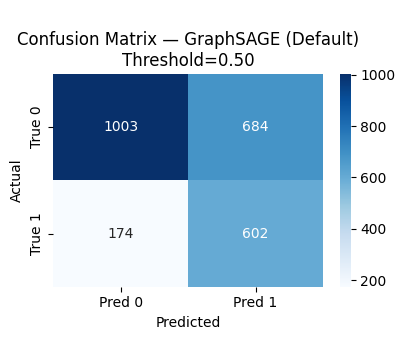


Confusion Matrix — GraphSAGE (Default) @ 0.50 — acc 0.652  prec 0.468  rec 0.776  f1 0.584  (prevalence=0.315)


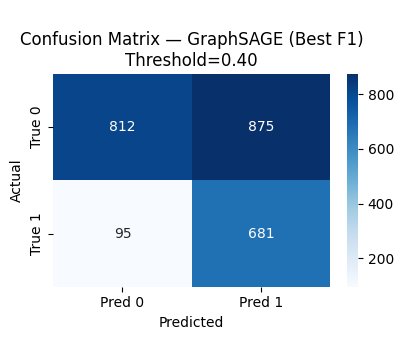


Confusion Matrix — GraphSAGE (Best F1) @ 0.40 — acc 0.606  prec 0.438  rec 0.878  f1 0.584  (prevalence=0.315)


In [22]:
# === Test evaluation + confusion matrices + RESULT CAPTURE (CPU only, no saves) ===
import numpy as np, math, torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, precision_recall_fscore_support
)

# -------- result stores kept in memory for later comparisons --------
MODEL_RESULTS = []            # one dict per model/split, e.g., {"model":"GraphSAGE", ...}
MODEL_PREDICTIONS = {}        # "GraphSAGE" -> {"y_true": ndarray, "y_prob": ndarray}

@torch.no_grad()
def collect_preds(model, loader, device):
    if loader is None:
        return np.array([]), np.array([])
    model.eval()
    ys, ps = [], []
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch.x, batch.edge_index, batch.batch)  # [B]
        probs  = torch.sigmoid(logits).view(-1).cpu().numpy()
        ys.append(batch.y.view(-1).cpu().numpy())
        ps.append(probs)
    y_true = np.concatenate(ys) if ys else np.array([])
    y_prob = np.concatenate(ps) if ps else np.array([])
    return y_true, y_prob

def plot_cm(y_true, y_prob, th, title):
    if y_true.size == 0 or y_prob.size == 0:
        print(f"[skip] {title}: empty inputs.")
        return None
    y_pred = (y_prob >= th).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # force 2x2
    plt.figure(figsize=(4.2, 3.5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 0","Pred 1"],
                yticklabels=["True 0","True 1"])
    plt.title(f"{title}\nThreshold={th:.2f}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    acc  = float((y_pred == y_true).mean()) if y_true.size else float("nan")
    prev = float(y_true.mean()) if y_true.size else float("nan")
    print(f"{title} @ {th:.2f} — acc {acc:.3f}  prec {prec:.3f}  rec {rec:.3f}  f1 {f1:.3f}  (prevalence={prev:.3f})")
    return {"acc":acc, "precision":prec, "recall":rec, "f1":f1, "cm":cm}

# ---------- 1) predictions on test ----------
y_true, y_prob = collect_preds(model, test_loader, device)
assert y_true.size and y_prob.size, "Empty test predictions (check test_loader)."
MODEL_PREDICTIONS["GraphSAGE"] = {"y_true": y_true, "y_prob": y_prob}

# ---------- 2) threshold-free metrics ----------
uniq = np.unique(y_true)
test_auroc = roc_auc_score(y_true, y_prob) if uniq.size > 1 else float("nan")
test_auprc = average_precision_score(y_true, y_prob) if uniq.size > 1 else float("nan")
print("\n=== Test metrics (threshold-free) ===")
print(f"AUROC: {test_auroc:.3f} | AUPRC: {test_auprc:.3f} | prevalence: {y_true.mean():.3f}")

# ---------- 3) F1 sweep to pick operating threshold ----------
ths = np.linspace(0.10, 0.90, 17)
best = {"th":0.50, "f1":-1.0, "rec":0.0, "prec":0.0}
for th in ths:
    y_pred = (y_prob >= th).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    if (f1 > best["f1"]) or (math.isclose(f1, best["f1"]) and rec > best["rec"]):
        best.update({"th": float(th), "f1": float(f1), "rec": float(rec), "prec": float(prec)})
print(f"Best-F1 threshold: {best['th']:.2f} (F1={best['f1']:.3f}, Recall={best['rec']:.3f})")

# ---------- 4) Confusion matrices (default 0.5 and best-F1) ----------
m_default = plot_cm(y_true, y_prob, 0.50, "\nConfusion Matrix — GraphSAGE (Default)")
m_best    = plot_cm(y_true, y_prob, best["th"], "\nConfusion Matrix — GraphSAGE (Best F1)")

# ---------- 5) capture a compact row for later comparison ----------
MODEL_RESULTS.append({
    "model": "GraphSAGE",
    "split": "test",
    "auroc": float(test_auroc),
    "auprc": float(test_auprc),
    "best_th": best["th"],
    "f1_best": best["f1"],
    "rec_best": best["rec"],
    "prec_best": best["prec"],
    "acc_at_0.5": (m_default["acc"] if m_default else float("nan")),
    "acc_at_best": (m_best["acc"] if m_best else float("nan")),
    "n": int(y_true.size),
    "prevalence": float(y_true.mean()),
})

# (Optional) quick peek:
# import pandas as pd; display(pd.DataFrame(MODEL_RESULTS))


# Statistical Metrics Approach

* Build simple, interpretable per-play features at ball snap (geometry, speed, counts).
* Standardize features and derive a single rule-based score (no Machine Learning).
* Choose a decision threshold on validation to maximize F1.
* Evaluate on test with AUROC/AUPRC and confusion matrices.
* Use results as a baseline to compare against GraphSAGE.


[Statistical Approach] TEST — AUROC=0.637 | AUPRC=0.415 | prevalence=0.315
[Statistical Approach] VAL  — best-F1 th=0.50 | F1=0.553 | Recall=0.866


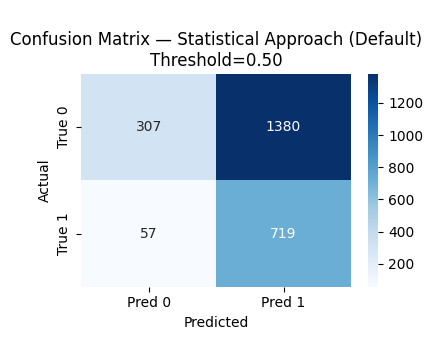


Confusion Matrix — Statistical Approach (Default) @ 0.50 — acc 0.417  prec 0.343  rec 0.927  f1 0.500  (prevalence=0.315)


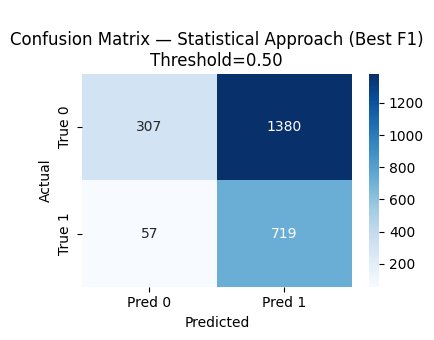


Confusion Matrix — Statistical Approach (Best F1) @ 0.50 — acc 0.417  prec 0.343  rec 0.927  f1 0.500  (prevalence=0.315)


In [23]:
# === Build val/test tables + Rule-based baseline (CPU only, no files) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix,
    precision_recall_fscore_support
)

# --- Required inputs from earlier cells:
# players_frame: ball-snap snapshot with columns ["gameId","playId","nflId","x","y","s","a","side","position_final"]
# val_graphs, test_graphs: lists of PyG Data objects with .gameId, .playId, .y
assert 'players_frame' in globals() and len(players_frame) > 0, "players_frame is missing/empty."
assert 'val_graphs' in globals() and 'test_graphs' in globals(), "val_graphs/test_graphs missing."

# -------- helpers to build features and labels --------
RECEIVER_POS = {"WR","TE","RB"}

def offense_side_by_qb(df):
    qb = df[df["position_final"] == "QB"]
    if qb.empty: return None
    side = str(qb.iloc[0]["side"])
    off = df[(df["side"] == side) & df["nflId"].notna()].copy()
    return off if not off.empty else None

def per_play_features(snap_df):
    req = {"gameId","playId","nflId","x","y","s","a","side","position_final"}
    missing = req - set(snap_df.columns)
    if missing:
        raise KeyError(f"players_frame missing columns: {missing}")
    rows = []
    for (gid, pid), g in snap_df.groupby(["gameId","playId"], sort=False):
        off = offense_side_by_qb(g)
        if off is None or len(off) < 5:
            continue
        width_y      = float(off["y"].max() - off["y"].min()) if off["y"].notna().any() else 0.0
        depth_x_std  = float(off["x"].std(ddof=0)) if off["x"].notna().sum() > 1 else 0.0
        mean_s       = float(off["s"].mean()) if off["s"].notna().any() else 0.0
        max_s        = float(off["s"].max()) if off["s"].notna().any() else 0.0
        mean_a       = float(off["a"].mean()) if off["a"].notna().any() else 0.0
        pos = off["position_final"].astype(str)
        n_wr = int((pos == "WR").sum()); n_te = int((pos == "TE").sum()); n_rb = int((pos == "RB").sum())
        n_elig = int(pos.isin(RECEIVER_POS).sum())
        # simple box count using defense around offense median
        los_x = float(off["x"].median()) if off["x"].notna().any() else np.nan
        deff = g[g["side"] != off.iloc[0]["side"]]
        if np.isfinite(los_x) and not deff.empty:
            band_y_min, band_y_max = float(off["y"].median()) - 8.0, float(off["y"].median()) + 8.0
            in_box = deff[(deff["x"] >= los_x - 3.0) & (deff["x"] <= los_x + 3.0) &
                          (deff["y"] >= band_y_min) & (deff["y"] <= band_y_max)]
            box_ct = int(len(in_box))
        else:
            box_ct = 0
        rows.append({
            "gameId": int(gid), "playId": int(pid),
            "off_width_y": width_y, "off_depth_x_std": depth_x_std,
            "off_mean_s": mean_s, "off_max_s": max_s, "off_mean_a": mean_a,
            "n_wr": n_wr, "n_te": n_te, "n_rb": n_rb, "n_elig": n_elig,
            "box_count": box_ct,
        })
    return pd.DataFrame(rows)

def meta_from_graphs(graph_list, split_name):
    rows = []
    for g in graph_list:
        gid = int(g.gameId.item()) if hasattr(g, "gameId") else int(g.gameId)
        pid = int(g.playId.item()) if hasattr(g, "playId") else int(g.playId)
        y   = int(g.y.item())      if hasattr(g, "y")      else int(g.y)
        rows.append({"gameId":gid, "playId":pid, "label":y, "split":split_name})
    return pd.DataFrame(rows)

def attach_features(meta, feats):
    df = meta.merge(feats, on=["gameId","playId"], how="left")
    num_cols = [c for c in df.columns if c not in ["gameId","playId","label","split"]]
    df[num_cols] = df[num_cols].fillna(0.0)
    return df

# -------- build val/test tables --------
stat_feats = per_play_features(players_frame)
val_df  = attach_features(meta_from_graphs(val_graphs,  "val"),  stat_feats)
test_df = attach_features(meta_from_graphs(test_graphs, "test"), stat_feats)
feat_cols = [c for c in val_df.columns if c not in ["gameId","playId","label","split"]]

# -------- rule-based baseline (no LR) --------
Xtr = val_df[feat_cols].to_numpy(np.float32); ytr = val_df["label"].to_numpy(np.int64)
Xte = test_df[feat_cols].to_numpy(np.float32); yte = test_df["label"].to_numpy(np.int64)
assert Xtr.shape[0] > 0 and Xte.shape[0] > 0, "Empty val/test for rule baseline."

ss = StandardScaler().fit(Xtr)
Ztr = ss.transform(Xtr); Zte = ss.transform(Xte)

# weights = Pearson corr on val (shrink small)
w = []
for j in range(Ztr.shape[1]):
    xj = Ztr[:, j]
    c = 0.0 if np.std(xj) < 1e-8 else np.corrcoef(xj, ytr)[0, 1]
    if not np.isfinite(c): c = 0.0
    w.append(c)
w = np.asarray(w, dtype=np.float32); w[np.abs(w) < 0.05] = 0.0

score_val, score_test = Ztr @ w, Zte @ w
def minmax01(a):
    mn, mx = np.min(a), np.max(a); return (a - mn) / (mx - mn + 1e-12)
prob_val, prob_test = minmax01(score_val), minmax01(score_test)

# pick threshold on val (F1, tie-break recall)
ths = np.linspace(0.10, 0.90, 17)
best = {"th":0.50, "f1":-1.0, "rec":0.0, "prec":0.0}
for th in ths:
    pred = (prob_val >= th).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(ytr, pred, average="binary", zero_division=0)
    if (f1 > best["f1"]) or (np.isclose(f1, best["f1"]) and rec > best["rec"]):
        best.update({"th": float(th), "f1": float(f1), "rec": float(rec), "prec": float(prec)})

# threshold-free test metrics
uniq = np.unique(yte)
auroc = roc_auc_score(yte, prob_test) if uniq.size > 1 else float("nan")
auprc = average_precision_score(yte, prob_test) if uniq.size > 1 else float("nan")
print(f"[Statistical Approach] TEST — AUROC={auroc:.3f} | AUPRC={auprc:.3f} | prevalence={yte.mean():.3f}")
print(f"[Statistical Approach] VAL  — best-F1 th={best['th']:.2f} | F1={best['f1']:.3f} | Recall={best['rec']:.3f}")

plot_cm(yte, prob_test, 0.50, "\nConfusion Matrix — Statistical Approach (Default)")
plot_cm(yte, prob_test, best["th"], "\nConfusion Matrix — Statistical Approach (Best F1)")

MODEL_RESULTS.append({
    "model": "Statistical Approach",
    "auroc": float(auroc),
    "auprc": float(auprc),
})


# Classic Machine Learning: Logistic Regression
* Build simple, interpretable per-play features at the snap.
* Create validation/test tables aligned with graph labels.
* Standardize features and train a Logistic Regression classifier (val → train, test → evaluate).
* Pick the decision threshold on validation to maximize F1.
* Report AUROC/AUPRC on the test set.
* Plot confusion matrices at the default and best-F1 thresholds.


[Logistic Regression] TEST — AUROC=0.652 | AUPRC=0.428 | prevalence=0.315
[Logistic Regression] VAL  — best-F1 th=0.50 | F1=0.570 | Recall=0.724


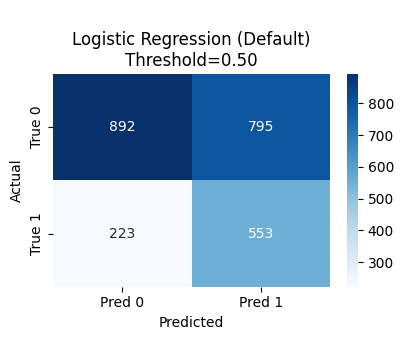


Logistic Regression (Default) @ 0.50 — acc 0.587  prec 0.410  rec 0.713  f1 0.521  (prevalence=0.315)


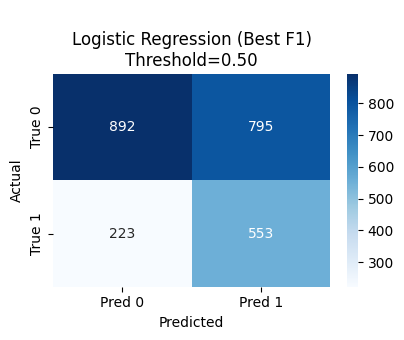


Logistic Regression (Best F1) @ 0.50 — acc 0.587  prec 0.410  rec 0.713  f1 0.521  (prevalence=0.315)


In [24]:
# === Stats-LR baseline (reuses existing val_df/test_df/feat_cols; CPU-only, no files) ===
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix,
    precision_recall_fscore_support
)

# minimal inline builders (only if your utilities aren’t defined)
RECEIVER_POS = {"WR","TE","RB"}
# def offense_side_by_qb(df):
#     qb = df[df["position_final"] == "QB"]
#     if qb.empty: return None
#     side = str(qb.iloc[0]["side"])
#     off = df[(df["side"] == side) & df["nflId"].notna()].copy()
#     return off if not off.empty else None

def build_snap_features(snap):
    rows = []
    for (gid, pid), g in snap.groupby(["gameId","playId"], sort=False):
        off = offense_side_by_qb(g)
        if off is None or len(off) < 5: continue
        width_y     = float(off["y"].max() - off["y"].min()) if off["y"].notna().any() else 0.0
        depth_x_std = float(off["x"].std(ddof=0)) if off["x"].notna().sum() > 1 else 0.0
        mean_s      = float(off["s"].mean()) if off["s"].notna().any() else 0.0
        max_s       = float(off["s"].max()) if off["s"].notna().any() else 0.0
        mean_a      = float(off["a"].mean()) if off["a"].notna().any() else 0.0
        pos = off["position_final"].astype(str)
        rows.append({
            "gameId": int(gid), "playId": int(pid),
            "off_width_y": width_y, "off_depth_x_std": depth_x_std,
            "off_mean_s": mean_s, "off_max_s": max_s, "off_mean_a": mean_a,
            "n_wr": int((pos == "WR").sum()),
            "n_te": int((pos == "TE").sum()),
            "n_rb": int((pos == "RB").sum()),
            "n_elig": int(pos.isin(RECEIVER_POS).sum()),
            "box_count": 0,  # keep minimal; full box calc lives in your utilities
        })
    return pd.DataFrame(rows)

def graphs_to_meta(graphs, split):
    return pd.DataFrame([{
        "gameId": int(getattr(g.gameId, "item", lambda: g.gameId)()),
        "playId": int(getattr(g.playId, "item", lambda: g.playId)()),
        "label":  int(getattr(g.y,      "item", lambda: g.y)()),
        "split":  split
    } for g in graphs])

# Build tables (if you already have val_df/test_df/feat_cols, you can skip this block)
feats   = build_snap_features(players_frame)
val_df  = graphs_to_meta(val_graphs,  "val").merge(feats, on=["gameId","playId"], how="left")
test_df = graphs_to_meta(test_graphs, "test").merge(feats, on=["gameId","playId"], how="left")
for df in (val_df, test_df):
    num_cols = [c for c in df.columns if c not in ["gameId","playId","label","split"]]
    df[num_cols] = df[num_cols].fillna(0.0)
feat_cols = [c for c in val_df.columns if c not in ["gameId","playId","label","split"]]

# ---------- Train LR on val; evaluate on test ----------
Xtr = val_df[feat_cols].to_numpy(np.float32); ytr = val_df["label"].to_numpy(np.int64)
Xte = test_df[feat_cols].to_numpy(np.float32); yte = test_df["label"].to_numpy(np.int64)

# Inline StandardScaler (no helper)
scaler = StandardScaler().fit(Xtr)
Xtr_s  = scaler.transform(Xtr)
Xte_s  = scaler.transform(Xte)

lr = LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs", random_state=42)
lr.fit(Xtr_s, ytr)

prob_val  = lr.predict_proba(Xtr_s)[:, 1]
prob_test = lr.predict_proba(Xte_s)[:, 1]

# ---------- Threshold selection (val) + metrics (test) ----------
def pick_threshold_f1(prob_val, y_val):
        ths = np.linspace(0.10, 0.90, 17)
        best = {"th":0.50, "f1":-1.0, "rec":0.0, "prec":0.0}
        for th in ths:
            pred = (prob_val >= th).astype(int)
            prec, rec, f1, _ = precision_recall_fscore_support(
                y_val, pred, average="binary", zero_division=0
            )
            if (f1 > best["f1"]) or (math.isclose(f1, best["f1"]) and rec > best["rec"]):
                best.update({"th": float(th), "f1": float(f1), "rec": float(rec), "prec": float(prec)})
        return best

def test_metrics(y_true, y_prob):
        uniq = np.unique(y_true)
        auroc = roc_auc_score(y_true, y_prob) if uniq.size > 1 else float("nan")
        auprc = average_precision_score(y_true, y_prob) if uniq.size > 1 else float("nan")
        return auroc, auprc

best = pick_threshold_f1(prob_val, ytr)        # uses your existing helper
auroc, auprc = test_metrics(yte, prob_test)    # uses your existing helper
print(f"[Logistic Regression] TEST — AUROC={auroc:.3f} | AUPRC={auprc:.3f} | prevalence={yte.mean():.3f}")
print(f"[Logistic Regression] VAL  — best-F1 th={best['th']:.2f} | F1={best['f1']:.3f} | Recall={best['rec']:.3f}")

# ---------- Confusion matrices ----------
plot_cm(yte, prob_test, 0.50, "\nLogistic Regression (Default)")  # uses your existing helper
plot_cm(yte, prob_test, best['th'], "\nLogistic Regression (Best F1)")

MODEL_RESULTS.append({
    "model": "Logistic Regression",
    "auroc": float(auroc),
    "auprc": float(auprc),
})


## Performance Comparison

* Graph Neural Network Approach
* Machine Learing: Logistic Regression
* Statistical Approach

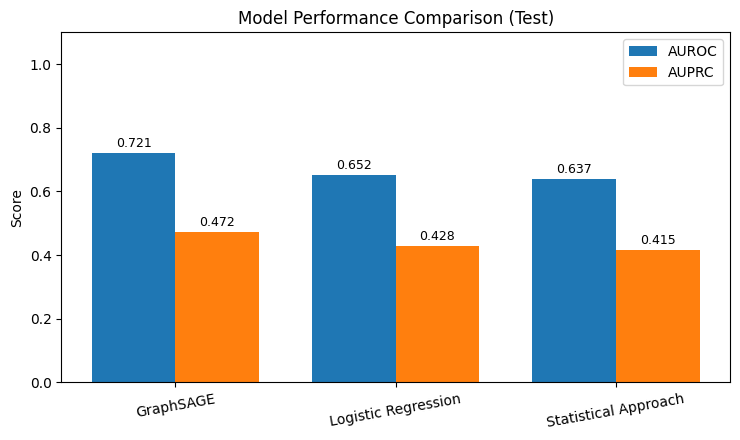

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Pick the *latest* entry per model name (in case multiple runs appended)
by_model = {}
for rec in MODEL_RESULTS:
    name = str(rec.get("model", ""))
    if name in {"GraphSAGE", "Logistic Regression", "Statistical Approach"}:
        by_model[name] = {"auroc": rec.get("auroc", np.nan), "auprc": rec.get("auprc", np.nan)}

models = [m for m in ["GraphSAGE", "Logistic Regression", "Statistical Approach"] if m in by_model]
if not models:
    raise ValueError("No comparable models found in MODEL_RESULTS.")

auroc_vals = [by_model[m]["auroc"] for m in models]
auprc_vals = [by_model[m]["auprc"] for m in models]

x = np.arange(len(models))
w = 0.38

plt.figure(figsize=(7.5, 4.5))
b1 = plt.bar(x - w/2, auroc_vals, width=w, label="AUROC")
b2 = plt.bar(x + w/2, auprc_vals, width=w, label="AUPRC")

# value labels
for bars in (b1, b2):
    for bar in bars:
        h = bar.get_height()
        if np.isfinite(h):
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.01, f"{h:.3f}", ha="center", va="bottom", fontsize=9)

plt.xticks(x, models, rotation=10)
plt.ylim(0, max([v for v in auroc_vals+auprc_vals if np.isfinite(v)] + [1.0]) * 1.10)
plt.ylabel("Score")
plt.title("Model Performance Comparison (Test)")
plt.legend()
plt.tight_layout()
plt.show()


## Data Mining of Winning Strategies

* Run batches through the GNN and pool node features to one embedding per play.
* Collect embeddings with (gameId, playId, label, split) metadata.
* Standardize embeddings; cluster (e.g., KMeans).
* (Optional) Project to 2D (UMAP/t-SNE) for visualization and join back to play info.


Embeddings: (16123, 130) | rows: 16123
Silhouette (original embedding space, k=6): 0.288


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


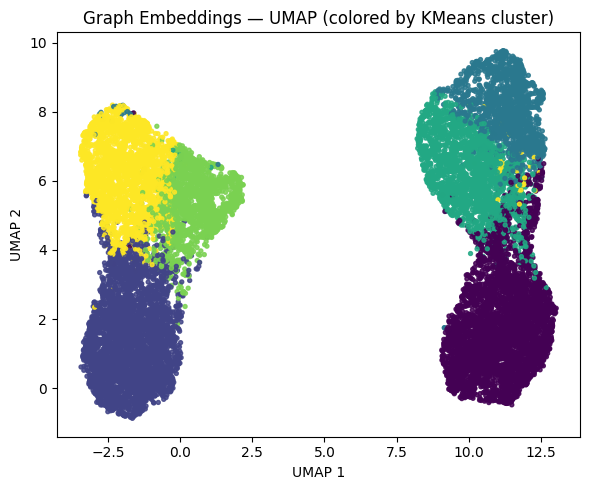

       gameId  playId  split  label  emb_cluster_k     umap_x    umap_y
0  2022100600     202  train      1              0  12.247362  0.899338
1  2022101610    3205  train      0              4  -0.434095  6.032079
2  2022100900    1019  train      0              5  -1.592136  5.561078
3  2022092600    3125  train      1              0  10.330804  3.683395
4  2022092900     479  train      1              0  10.542331  1.494569


In [26]:
# === Embedding extraction + KMeans + UMAP (CPU-only, no saves) ===
import numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap

# 1) Collect graph-level embeddings from the trained model
@torch.no_grad()
def collect_graph_embeddings(model, loader, device, split_name):
    from torch_geometric.nn import global_mean_pool
    if loader is None:
        return None
    model.eval()
    embs, labels, gids, pids, splits = [], [], [], [], []
    for batch in loader:
        batch = batch.to(device)
        x = model.conv1(batch.x, batch.edge_index); x = torch.relu(model.bn1(x))
        x = model.conv2(x, batch.edge_index);       x = torch.relu(model.bn2(x))
        x = model.conv3(x, batch.edge_index);       x = torch.relu(model.bn3(x))
        g = global_mean_pool(x, batch.batch)  # [num_graphs, 128]
        embs.append(g.cpu().numpy())
        labels.append(batch.y.view(-1).cpu().numpy())
        gids.append(batch.gameId.view(-1).cpu().numpy())
        pids.append(batch.playId.view(-1).cpu().numpy())
        splits.extend([split_name] * g.size(0))
    if not embs:
        return None
    E = np.vstack(embs)
    meta = pd.DataFrame({
        "gameId": np.concatenate(gids).astype(int),
        "playId": np.concatenate(pids).astype(int),
        "label":  np.concatenate(labels).astype(int),
        "split":  splits
    })
    emb_df = pd.DataFrame(E, columns=[f"e{i}" for i in range(E.shape[1])])
    return pd.concat([meta, emb_df], axis=1)

tables = []
for name, loader in [("train", globals().get("train_loader")),
                     ("val",   globals().get("val_loader")),
                     ("test",  globals().get("test_loader"))]:
    tbl = collect_graph_embeddings(model, loader, device, name)
    if tbl is not None: tables.append(tbl)

EMB = pd.concat(tables, ignore_index=True)
print("Embeddings:", EMB.filter(like="e").shape, "| rows:", len(EMB))

# 2) Cluster in ORIGINAL embedding space (not in UMAP space)
E = EMB.filter(like="e").to_numpy(np.float32)
E_std = StandardScaler().fit_transform(E)
k = 6
km = KMeans(n_clusters=k, n_init=20, random_state=42).fit(E_std)
EMB["emb_cluster_k"] = km.labels_.astype(int)

# Silhouette in original embedding space (higher is better; ~[-1,1])
sil = silhouette_score(E_std, EMB["emb_cluster_k"].to_numpy())
print(f"Silhouette (original embedding space, k={k}): {sil:.3f}")

# 3) UMAP projection for visualization only
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
Z = reducer.fit_transform(E_std)
EMB["umap_x"], EMB["umap_y"] = Z[:,0], Z[:,1]

plt.figure(figsize=(6,5))
plt.scatter(EMB["umap_x"], EMB["umap_y"], c=EMB["emb_cluster_k"], s=8, alpha=0.85)
plt.title("Graph Embeddings — UMAP (colored by KMeans cluster)")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.tight_layout(); plt.show()

# (Optional) peek
print(EMB[["gameId","playId","split","label","emb_cluster_k","umap_x","umap_y"]].head())


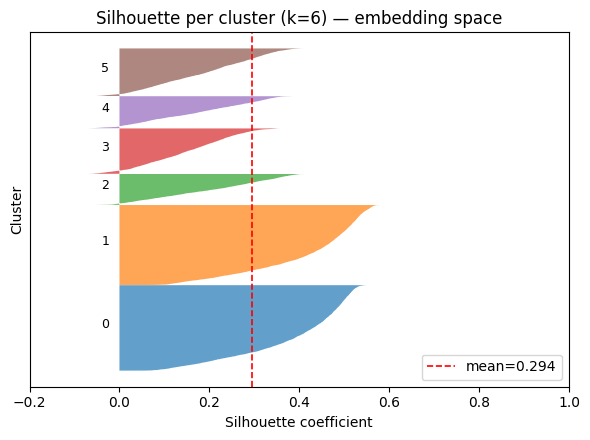

UMAP trustworthiness (k=15): 0.967


In [27]:
# === UMAP quality & silhouette visualization (CPU-only, no saves) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import trustworthiness

# --- Expect EMB from previous cell with columns e0..e(d-1), 'emb_cluster_k', 'umap_x','umap_y'
assert 'EMB' in globals(), "Run the embedding extraction + UMAP block first."

# Reconstruct standardized embeddings and labels if needed
E = EMB.filter(like="e").to_numpy(np.float32)
E_std = StandardScaler().fit_transform(E)
labels = EMB["emb_cluster_k"].to_numpy()
k = len(np.unique(labels))

# 1) Silhouette score (in ORIGINAL embedding space)
sil = silhouette_score(E_std, labels)
sil_samples = silhouette_samples(E_std, labels)

# --- Silhouette plot
fig, ax = plt.subplots(figsize=(6, 4.5))
y_lower = 10
for c in sorted(np.unique(labels)):
    vals = sil_samples[labels == c]
    vals.sort()
    size = len(vals)
    y_upper = y_lower + size
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, vals, alpha=0.7, linewidth=0)
    ax.text(-0.04, y_lower + 0.5*size, str(c), fontsize=9)
    y_lower = y_upper + 10  # spacing between clusters

ax.axvline(x=sil, color="red", linestyle="--", linewidth=1.2, label=f"mean={sil:.3f}")
ax.set_title(f"Silhouette per cluster (k={k}) — embedding space")
ax.set_xlabel("Silhouette coefficient")
ax.set_ylabel("Cluster")
ax.set_xlim([-0.2, 1.0])
ax.set_yticks([])
ax.legend(loc="lower right")
plt.tight_layout(); plt.show()

# 2) UMAP trustworthiness (higher is better)
Z = EMB[["umap_x","umap_y"]].to_numpy()
tw = trustworthiness(E_std, Z, n_neighbors=15)
print(f"UMAP trustworthiness (k=15): {tw:.3f}")

# # 3) UMAP scatter with cluster centroids overlaid
# fig, ax = plt.subplots(figsize=(6, 5))
# sc = ax.scatter(EMB["umap_x"], EMB["umap_y"], c=labels, s=8, alpha=0.8)
# # centroids computed as means in UMAP space (for visualization only)
# centroids = EMB.groupby("emb_cluster_k")[["umap_x","umap_y"]].mean()
# ax.scatter(centroids["umap_x"], centroids["umap_y"], marker="X", s=120, c=centroids.index, edgecolor="k")
# for c, row in centroids.iterrows():
#     ax.text(row["umap_x"], row["umap_y"], f" {c}", va="center", ha="left", fontsize=9, weight="bold")
# ax.set_title(f"Graph Embeddings — UMAP (k={k})  |  trustworthiness={tw:.3f}")
# ax.set_xlabel("UMAP 1"); ax.set_ylabel("UMAP 2")
# plt.tight_layout(); plt.show()


In [55]:
# --- compute formation stats WITHOUT .apply(...) to avoid the warning ---
import numpy as np

TOP_N = 50  # increase to show more winning formations in the tables

# 0) Build EP from EMB + plays_df (no change to previous blocks)
#    - EMB has: gameId, playId, label, emb_cluster_k
#    - plays_df has: offenseFormation (plus other play metadata)
assert 'EMB' in globals(), "Run the embedding block first to create EMB."
assert 'plays_df' in globals(), "plays_df must be loaded (plays.csv)."
assert {'gameId','playId','label','emb_cluster_k'}.issubset(EMB.columns), "EMB missing required columns."
assert 'offenseFormation' in plays_df.columns, "plays_df missing offenseFormation."

EP = (
    EMB[['gameId','playId','label','emb_cluster_k']].drop_duplicates()
      .merge(
          plays_df[['gameId','playId','offenseFormation']],
          on=['gameId','playId'], how='left'
      )
      .rename(columns={'label':'isWinningPass', 'offenseFormation':'formation'})
)

# 1) Pick BEST cluster
#    Option A: use silhouette results if they exist in globals (from your silhouette cell)
best_k = 0  # sensible default (your plot showed cluster 0 was best)
if 'sil_samples' in globals() and 'labels' in globals():
    try:
        uniq = np.unique(labels)
        best_k = int(uniq[np.argmax([sil_samples[labels == c].mean() for c in uniq])])
    except Exception:
        pass
#    Option B (fallback): choose cluster with highest success rate
try:
    sr = EP.groupby('emb_cluster_k')['isWinningPass'].mean()
    best_k = int(sr.idxmax())
except Exception:
    pass

BEST = EP[EP['emb_cluster_k'] == best_k].copy()

# 2) Best cluster stats
best_stats = (
    BEST.groupby("formation")["isWinningPass"]
        .agg(play_count_in_cluster="count", success_rate_in_cluster="mean")
        .reset_index()
)

# 3) Global stats (across all clusters)
global_stats = (
    EP.dropna(subset=["formation"])
      .groupby("formation")["isWinningPass"]
      .agg(play_count_global="count", success_rate_global="mean")
      .reset_index()
)

# 4) Join + lift
df = (
    best_stats.merge(global_stats, on="formation", how="left")
              .dropna(subset=["success_rate_in_cluster","success_rate_global"])
)
df = df[df["play_count_in_cluster"] >= 10].copy()
df["lift"] = df["success_rate_in_cluster"] - df["success_rate_global"]

# 5) Top-N by lift and by frequency
top_lift = (df.sort_values(["lift","success_rate_in_cluster","play_count_in_cluster"], ascending=False)
              .head(TOP_N))
top_freq = (df.sort_values(["play_count_in_cluster","success_rate_in_cluster"], ascending=[False, False])
              .head(TOP_N))

# 6) Pretty print
for t in (top_lift, top_freq):
    for c in ["success_rate_in_cluster","success_rate_global","lift"]:
        t[c] = t[c].map(lambda x: f"{x:.3f}")

print(f"(BEST cluster auto-selected = {best_k})")
# print(f"\nTop formations in BEST cluster — ranked by LIFT (success over global):")
# display(top_lift[["formation","play_count_in_cluster","success_rate_in_cluster","success_rate_global","lift","play_count_global"]])

# print(f"\nTop formations in BEST cluster — ranked by FREQUENCY:")
# display(top_freq[["formation","play_count_in_cluster","success_rate_in_cluster","success_rate_global","lift","play_count_global"]])
print(f"\nTop formations in BEST cluster — ranked by FREQUENCY:")
display(top_freq[["formation","play_count_in_cluster","success_rate_in_cluster","success_rate_global","play_count_global"]])

(BEST cluster auto-selected = 1)

Top formations in BEST cluster — ranked by FREQUENCY:


,formation,play_count_in_cluster,success_rate_in_cluster,success_rate_global,play_count_global
4,SHOTGUN,2911,0.508,0.407,8791
0,EMPTY,631,0.566,0.539,1342
5,SINGLEBACK,290,0.441,0.187,3915
3,PISTOL,80,0.463,0.193,641
1,I_FORM,73,0.438,0.157,1035


In [56]:
# === Example play descriptions for SINGLEBACK & SHOTGUN (best cluster, successful passes) ===
import pandas as pd
from textwrap import shorten

# ---- Guards
for col in ["gameId","playId","emb_cluster_k"]:
    assert col in EMB.columns, f"EMB missing {col}"
need_plays = {"gameId","playId","passResult","yardsGained","offenseFormation"}
assert need_plays.issubset(plays_df.columns), f"plays_df missing {need_plays - set(plays_df.columns)}"

# Rebuild/ensure EP and BEST if they aren't in scope
if "EP" not in globals():
    P_ = plays_df[list(need_plays)].copy()
    pr = P_["passResult"].astype("string").str.strip().str.upper()
    yg = P_["yardsGained"].fillna(0)
    P_["isWinningPass"] = (pr.eq("C") & (yg > 0)).astype(int)
    P_["formation"] = P_["offenseFormation"].astype("string").str.strip()
    EP = EMB[["gameId","playId","emb_cluster_k"]].drop_duplicates().merge(
        P_[["gameId","playId","isWinningPass","formation"]],
        on=["gameId","playId"], how="left"
    )

if "best_k" not in globals():
    counts = EP.groupby("emb_cluster_k", as_index=False)["isWinningPass"]\
               .agg(n="count", succ_rate="mean")
    counts = counts[counts["n"] >= 50] if (counts["n"] >= 50).any() else counts
    best_k = int(counts.sort_values(["succ_rate","n"], ascending=[False, False])
                        .iloc[0]["emb_cluster_k"])

BEST = EP[(EP["emb_cluster_k"] == best_k)].copy()

# Attach playDescription if available
desc_col = "playDescription" if "playDescription" in plays_df.columns else None
if desc_col:
    BEST = BEST.merge(
        plays_df[["gameId","playId",desc_col,"yardsGained","passResult"]],
        on=["gameId","playId"], how="left"
    )
else:
    # still keep yards/pass if present
    extra_cols = [c for c in ["yardsGained","passResult"] if c in plays_df.columns]
    if extra_cols:
        BEST = BEST.merge(plays_df[["gameId","playId"] + extra_cols], on=["gameId","playId"], how="left")

def show_examples_for(formation_name, n=10):
    df = BEST[
        (BEST["formation"].astype("string").str.upper() == formation_name.upper()) &
        (BEST["isWinningPass"] == 1)
    ].copy()

    if df.empty:
        print(f"\nNo successful-pass examples found for formation: {formation_name}")
        return

    # Pick up to n examples (random but reproducible)
    df = df.sample(n=min(n, len(df)), random_state=42)

    cols = ["gameId","playId","yardsGained","passResult"]
    if desc_col:
        # shorten long descriptions for display
        df[desc_col] = df[desc_col].astype("string").apply(lambda s: shorten(s, width=140, placeholder="…"))
        cols.append(desc_col)

    print(f"\nExample plays for formation: {formation_name} (best cluster, successful passes) — showing {len(df)}")
    display(df[cols].reset_index(drop=True))

# Show examples for SINGLEBACK and SHOTGUN
show_examples_for("SINGLEBACK", n=10)
show_examples_for("SHOTGUN",   n=10)



Example plays for formation: SINGLEBACK (best cluster, successful passes) — showing 10


,gameId,playId,yardsGained,passResult,playDescription
0,2022100908,528,7,C,(6:16) T.Brady pass short left to R.White to A...
1,2022091802,2606,27,C,(4:27) C.Wentz pass deep right to C.Samuel pus...
2,2022092513,579,16,C,(7:05) J.Garoppolo pass short middle to B.Aiyu...
3,2022100200,2439,15,C,(8:44) A.Dalton pass short left to M.Callaway ...
4,2022102308,185,12,C,(12:37) D.Carr pass short left to D.Adams to H...
5,2022092509,1443,9,C,(8:11) J.Herbert pass short middle to S.Michel...
6,2022091802,1209,9,C,(12:10) J.Goff pass short right to D.Swift to ...
7,2022103002,1431,22,C,(8:13) D.Prescott pass short right to C.Lamb t...
8,2022100906,493,18,C,(6:36) A.Dalton pass deep right to C.Olave to ...
9,2022102000,145,53,C,(13:02) A.Dalton pass deep middle to R.Shaheed...



Example plays for formation: SHOTGUN (best cluster, successful passes) — showing 10


,gameId,playId,yardsGained,passResult,playDescription
0,2022100211,1899,32,C,(14:48) (Shotgun) A.Rodgers pass deep right to...
1,2022091102,1631,6,C,(5:28) (Shotgun) T.Lance pass short right to J...
2,2022092510,719,13,C,(4:00) (Shotgun) K.Murray pass short left to M...
3,2022101607,2960,6,C,(3:22) (Shotgun) T.Brady pass short middle to ...
4,2022101605,2298,11,C,(14:16) (Shotgun) A.Dalton pass short right to...
5,2022102311,1825,21,C,(:26) (Shotgun) T.Tagovailoa pass deep right t...
6,2022102700,4159,6,C,"(1:12) (No Huddle, Shotgun) T.Brady pass short..."
7,2022091105,4731,9,C,"(1:06) (No Huddle, Shotgun) D.Mills pass short..."
8,2022100902,3038,2,C,(3:07) (Shotgun) J.Brissett pass short left to...
9,2022100200,1911,7,C,(:16) (Shotgun) K.Cousins pass short left to I...
